# Data analysis

This notebooks is used to analyse bunch electrons in a Plasma Wakefield simulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import openpmd_api as io
from scipy import constants, stats
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm, SymLogNorm, Normalize, hsv_to_rgb, Normalize

# Set the default text font size
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
#Set the font size for x tick labels
plt.rc('xtick', labelsize=14)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=14)
# Set the legend font size
plt.rc('legend', fontsize=16)
# Set the font size of the figure title
plt.rc('figure', titlesize=18)

In [2]:
#path="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/test/simOutput/openPMD/simData_beta_%T.bp"
path="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_field="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_%T.bp"

## Definitions

Define different functions for data fitting.

In [3]:
def y_center(t, t_0, y_0):
    Delta_t = 1.706e-16/1.28631
    y_diff = y_0 + Delta_t * constants.c * (t-t_0) * 1e6

    return(y_diff)

In [4]:
def window(series, t_0):
    """Returns start and end of viewing window in both directions and difference factor between y so driver is always centered at 0."""
    y_cells = 2048
    z_cells = 1024      # should be same as x_cells
    y_gpus = 8
    cellwidth = 0.5 * 0.1772e-6   # same for all directions
    Delta_t = 1.706e-16/1.28631
    windowwidth = y_cells * (y_gpus-1)/y_gpus * cellwidth * 1e6 # in \mu m
    windowheight = z_cells * cellwidth * 1e6 # in \mu m
    
    par_beg = particlePMD(series.iterations[t_0].particles["b_all"], series)
    y_0 = np.mean(par_beg.y_pos)
        
#    y_min = -windowwidth * 2.4/4 *0.15
#    y_max = windowwidth * 1.6/4 *0.15
#    z_min = -windowheight / 3
#    z_max =  windowheight / 3

    y_min = -windowwidth * 2.4/4 *0.2
    y_max = windowwidth * 1.6/4 *0.2
    z_min = -windowheight / 2
    z_max =  windowheight / 2
        
    return y_min, y_max, z_min, z_max, y_0

In [5]:
def time_to_dist(time, array=False):
    Delta_t = 1.706e-16/1.28631
    cellwidth = 0.5 * 0.1772e-6   # same for all directions
    start_pos = (10191 * 1.02) * Delta_t * constants.c + 2048 * cellwidth
    
    t_min = time[0]
    t_max = time[-1]
    t_diff = (t_max-t_min) / (len(time)-1)
    d_min = ((t_min - t_diff/2) * Delta_t * constants.c - start_pos) * 1e3
    d_max = ((t_max + t_diff/2) * Delta_t * constants.c - start_pos) * 1e3
    d_array = (time * Delta_t * constants.c - start_pos) * 1e3
    if array:
        return d_min, d_max, d_array
    else:
        return d_min, d_max

In [6]:
def Gauss(x, a, b, c):
    y = a * np.exp(-(x-b)**2 / (2*c**2))
    return y

def Gauss_dens(x, a, b):
    y = 1/np.sqrt(2*np.pi * b**2) * np.exp(-(x-a)**2 / (2*b**2))
    return y

def Gauss2(x, a1, b1, c1, a2, b2, c2):
    y = a1 * np.exp(-(x-b1)**2 / (2*c1**2)) + a2 * np.exp(-(x-b2)**2 / (2*c2**2))
    return y

def Gauss3(x, a1, b1, c1):
    y = c1 * np.exp(-(x-a1)**2 / (2*b1**2))
    return y

def Lorentz(x, a, b):
    y = 2/np.pi * b / (4*(x - a)**2 + b)
    return y

def Max_Boltz_2D(x, a):
    y = x/a * np.exp(-x**2 / (2*a))
    return y

In [7]:
class particlePMD:
    def __init__(self, particle, series_par):
        x_off = particle["positionOffset"]["x"][:]
        x_off_unit = particle["positionOffset"]["x"].unit_SI
        y_off = particle["positionOffset"]["y"][:]
        y_off_unit = particle["positionOffset"]["y"].unit_SI
        z_off = particle["positionOffset"]["z"][:]
        z_off_unit = particle["positionOffset"]["z"].unit_SI

        x = particle["position"]["x"][:]
        x_unit = particle["position"]["x"].unit_SI
        y = particle["position"]["y"][:]
        y_unit = particle["position"]["y"].unit_SI
        z = particle["position"]["z"][:]
        z_unit = particle["position"]["z"].unit_SI

        p_x = particle["momentum"]["x"][:]
        p_x_unit = particle["momentum"]["x"].unit_SI
        p_y = particle["momentum"]["y"][:]
        p_y_unit = particle["momentum"]["y"].unit_SI
        p_z = particle["momentum"]["z"][:]
        p_z_unit = particle["momentum"]["z"].unit_SI

        x_probeE = particle['probeE']['x'][:]
        x_probeE_unit = particle["probeE"]["x"].unit_SI 
        y_probeE = particle['probeE']['y'][:]
        y_probeE_unit = particle["probeE"]["y"].unit_SI
        z_probeE = particle['probeE']['z'][:]
        z_probeE_unit = particle["probeE"]["z"].unit_SI

        x_probeB = particle['probeB']['x'][:]
        x_probeB_unit = particle["probeB"]["x"].unit_SI 
        y_probeB = particle['probeB']['y'][:]
        y_probeB_unit = particle["probeB"]["y"].unit_SI
        z_probeB = particle['probeB']['z'][:]
        z_probeB_unit = particle["probeB"]["z"].unit_SI

        particleId = particle["id"][io.Mesh_Record_Component.SCALAR][:]
        particleId_unit = particle["id"][io.Mesh_Record_Component.SCALAR].unit_SI 
        weight = particle["weighting"][io.Mesh_Record_Component.SCALAR][:]
        weight_unit = particle["weighting"][io.Mesh_Record_Component.SCALAR].unit_SI

        series_par.flush()

        self.x_pos = (x * x_unit + (x_off-512) * x_off_unit) * 1e6
        self.y_pos = (y * y_unit +  y_off      * y_off_unit) * 1e6
        self.z_pos = (z * z_unit + (z_off-512) * z_off_unit) * 1e6
        
        self.x_mom = p_x * p_x_unit
        self.y_mom = p_y * p_y_unit
        self.z_mom = p_z * p_z_unit
        
        self.x_probeE = x_probeE * x_probeE_unit
        self.y_probeE = y_probeE * y_probeE_unit
        self.z_probeE = z_probeE * z_probeE_unit
        
        self.x_probeB = x_probeB * x_probeB_unit
        self.y_probeB = y_probeB * y_probeB_unit
        self.z_probeB = z_probeB * z_probeB_unit
        
        self.particleId = particleId * particleId_unit
        self.weight = np.float64(weight * weight_unit)
        
    def Energy(self):
        """returns kinetic energy of a macroparticle in MeV."""
        # squared total momentum
        p2_total = np.float64(self.x_mom**2 + self.y_mom**2 + self.z_mom**2)
        # energy per macro particle in Joule
        E_J = (constants.c * np.sqrt((constants.m_e*self.weight)**2 * constants.c**2 + p2_total) - (constants.m_e*self.weight) * constants.c**2) * 1/self.weight
        # conversion to MeV
        E = E_J / constants.e / 1e6
        
        return E
        
    def LorentzForce(self):
        """returns components of the Lorentz force on a macroparticle in mu N."""
        x_vel = np.sqrt((self.x_mom / (constants.m_e*self.weight))**2 / (1 + (self.x_mom**2 + self.y_mom**2 + self.z_mom**2) / (constants.m_e*self.weight)**2 / constants.c**2))
        y_vel = np.sqrt((self.y_mom / (constants.m_e*self.weight))**2 / (1 + (self.x_mom**2 + self.y_mom**2 + self.z_mom**2) / (constants.m_e*self.weight)**2 / constants.c**2))
        z_vel = np.sqrt((self.z_mom / (constants.m_e*self.weight))**2 / (1 + (self.x_mom**2 + self.y_mom**2 + self.z_mom**2) / (constants.m_e*self.weight)**2 / constants.c**2))

        F_x_B = y_vel*self.z_probeB - z_vel*self.y_probeB
        F_y_B = z_vel*self.x_probeB - x_vel*self.z_probeB
        F_z_B = x_vel*self.y_probeB - y_vel*self.x_probeB

        F_x_L = -constants.e*self.weight * (self.x_probeE + F_x_B) * 1e6
        F_y_L = -constants.e*self.weight * (self.y_probeE + F_y_B) * 1e6
        F_z_L = -constants.e*self.weight * (self.z_probeE + F_z_B) * 1e6
        
        return F_x_L, F_y_L, F_z_L

In [8]:
def binned_to_grid(bin_x, bin_y):
    """Transforms 2D bins into grid.
    The left borders of the bins are taken as gridpoints, the rightmost border is discarded.
    """
    x_width = bin_x[1] - bin_x[0]
    y_width = bin_y[1] - bin_y[0]
    x = bin_x[:-1] + x_width/2
    y = bin_y[:-1] + y_width/2
    
    return x, y

## Density fields

Plots the charge-, energy-density and E-fields for b- and e-Particles

In [ ]:
#time = np.array([12000, 24000, 32000, 52000, 92000,  112000])
path_field3="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/034_particles_bachelor1/simOutput/openPMD/simData_%T.bp"
time = np.arange(12000, 170000+1, 4000)
series = io.Series(path_field3, io.Access.read_only)
cellwidth = 0.5 * 0.1772e-6 * 1e6   # in micorometer, same for all directions
d_min, dmax, d_array = time_to_dist(time, array=True)

#Delta_t = 1.706e-16/1.28631
#cellwidth2 = 0.5 * 0.1772e-6   # same for all directions
#start_pos = (10191 * 1.02) * Delta_t * constants.c + 2048 * cellwidth2
#d_array = (time * Delta_t * constants.c - start_pos) * 1e3

y_start = 600
y_end = 1300
z_start = 256
z_end = 512+z_start

z_min = -(z_start-0.5)*cellwidth
z_max = (z_start-0.5)*cellwidth
y_min = (y_start-0.5)*cellwidth-100
y_max = (y_end-0.5)*cellwidth-100

y = np.arange(y_start, y_end)*cellwidth-100
z = np.arange(-z_start, z_start)*cellwidth

e_dens_hist = np.zeros((len(time), y_end-y_start))
E_field_hist = np.zeros((len(time), y_end-y_start))

for i, t in enumerate(time):
    
    e_field_charge = series.iterations[t].meshes["e_all_chargeDensity"][io.Mesh_Record_Component.SCALAR][z_start:z_end,y_start:y_end,512]
    e_field_charge_unit = series.iterations[t].meshes["e_all_chargeDensity"][io.Mesh_Record_Component.SCALAR].unit_SI
#    e_field_energy = series.iterations[t].meshes["e_all_energyDensity"][io.Mesh_Record_Component.SCALAR][z_start:z_end,y_start:y_end,512]
#    e_field_energy_unit = series.iterations[t].meshes["e_all_energyDensity"][io.Mesh_Record_Component.SCALAR].unit_SI
    b_field_charge = series.iterations[t].meshes["b_all_chargeDensity"][io.Mesh_Record_Component.SCALAR][z_start:z_end,y_start:y_end,512]
    b_field_charge_unit = series.iterations[t].meshes["b_all_chargeDensity"][io.Mesh_Record_Component.SCALAR].unit_SI
#    b_field_energy = series.iterations[t].meshes["b_all_energyDensity"][io.Mesh_Record_Component.SCALAR][z_start:z_end,y_start:y_end,512]
#    b_field_energy_unit = series.iterations[t].meshes["b_all_energyDensity"][io.Mesh_Record_Component.SCALAR].unit_SI
#    E_field_x = series.iterations[t].meshes["E"]["x"][z_start:z_end,y_start:y_end,512]
#    E_field_x_unit = series.iterations[t].meshes["E"]["x"].unit_SI
#    E_field_y = series.iterations[t].meshes["E"]["y"][z_start:z_end,y_start:y_end,512]
#    E_field_y_unit = series.iterations[t].meshes["E"]["y"].unit_SI
#    E_field_z = series.iterations[t].meshes["E"]["z"][z_start:z_end,y_start:y_end,512]
#    E_field_z_unit = series.iterations[t].meshes["E"]["z"].unit_SI
    
    series.flush()
    
    # unit conversion
    # charge in pC/um^2 = C/m^2
    e_field_charge *= e_field_charge_unit*1e-6
    b_field_charge *= b_field_charge_unit*1e-6
#    e_field_energy *= e_field_energy_unit/constants.e*1e-12
#    b_field_energy *= b_field_energy_unit/constants.e*1e-12
#    E_field_x *= E_field_x_unit*1e-9
#    E_field_y *= E_field_y_unit*1e-9
#    E_field_z *= E_field_z_unit*1e-9
#    abs_Eyz = np.sqrt(E_field_x**2 + E_field_y**2 + E_field_z**2)

#    print("E_field: "       , np.min(E_field_y)     , np.max(E_field_y))
    print("e_field_charge: ", np.min(e_field_charge), np.max(e_field_charge))
#    print("e_field_energy: ", np.min(e_field_energy), np.max(e_field_energy))
    print("b_field_charge: ", np.min(b_field_charge), np.max(b_field_charge))
#    print("b_field_energy: ", np.min(b_field_energy), np.max(b_field_energy))
    
    e_dens_hist[i] = e_field_charge[int((z_end-z_start)/2),:]
#    E_field_hist[i] = E_field_y[int((z_end-z_start)/2),:]
    
    plot = True
    if plot:
        #plt.figure(figsize=(8, 3.5), dpi=70)
        plt.figure(figsize=(7.5, 6), dpi=70)

#        plt.subplot(121)
        plt.imshow(-e_field_charge, cmap='hot_r', norm=LogNorm(vmin=1e-3, vmax=1e2), extent=(y_min, y_max, z_min, z_max), aspect='equal', origin="lower", interpolation='none')
        plt.colorbar(label="$-dQ_{e^-}/dx/dy/dz \, \mathrm{[pC/\mu m^3]}$")    
        plt.imshow(-b_field_charge, cmap='Greens', norm=LogNorm(vmin=1e-3, vmax=1e1), extent=(y_min, y_max, z_min, z_max), aspect='equal', origin="lower", interpolation='none')
        plt.colorbar(label="$-dQ_{bunch}/dx/dy/dz \, \mathrm{[pC/\mu m^3]}$") 
        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
        plt.ylabel("$z \, \mathrm{[\mu m]}$")
        plt.title("plasma density, $y$ = {:.1f} mm".format(d_array[i]))

#        plt.subplot(222)
#        plt.imshow(e_field_energy, cmap='hot_r', norm=LogNorm(vmin=1e15, vmax=2e20), extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
#        plt.colorbar(label="$dE_{e^-}/dx/dy/dz \, \mathrm{[MeV/\mu m^3]}$")    
#        plt.imshow(b_field_energy, cmap='Greens', norm=LogNorm(vmin=1e17, vmax=1e22), extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
#        plt.colorbar(label="$dE_{bunch}/dx/dy/dz \, \mathrm{[MeV/\mu m^3]}$")    
#        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
#        plt.ylabel("$z \, \mathrm{[\mu m]}$")
#        plt.title("energy density, timestep = {}".format(t))

#        plt.subplot(122)
#        plt.imshow(E_field_y, cmap='Spectral', vmin=-2e2, vmax=2e2, extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
#        plt.colorbar(label="$E_y \, \mathrm{[GV/m]}$")    
#        plt.streamplot(y, z, E_field_y, E_field_z, color=abs_Eyz, cmap='magma_r', density=2, norm=Normalize(vmin=0, vmax=3e2))
#        plt.colorbar(label="$\left|\\vec{E}\\right| \, \mathrm{[GV/m]}$")    
#        plt.imshow(-b_field_charge, cmap='Greens', norm=LogNorm(vmin=1e-3, vmax=2e1), extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
#        plt.colorbar(label="$-dQ_{bunch}/dx/dy/dz \, \mathrm{[pC/\mu m^3]}$") 
#        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
#        plt.ylabel("$z \, \mathrm{[\mu m]}$")
#        plt.title("E-field, timestep = {}".format(t))
        
        plt.subplots_adjust(bottom=0.2, right=1)

        plt.show()
        #plt.savefig(fname="../Vortrag/Images/plasma_{:.1f}mm.png".format(d_array[i]), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/Frames/plasma/step_{}.png".format(t), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/test.png", facecolor="white", dpi=200)

del series


In [ ]:
d_min, dmax = time_to_dist(time)
Delta_t = 1.706e-16/1.28631

fig = plt.figure(dpi=60, figsize=(20, 6))

plt.subplot(121)
plt.imshow(-e_dens_hist, cmap="hot_r", origin="lower", aspect='auto', norm=LogNorm(vmin=1e-3, vmax=2e2), extent=(y_min, y_max, d_min, dmax), interpolation='none')
plt.colorbar(label="$-dQ_{e^-}/dx/dy/dz \, \mathrm{[pC/\mu m^3]}$")
plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
plt.ylabel("$y \,[mm]$")

E_gain = -4000 * Delta_t * constants.c * np.sum(E_field_hist, axis=0) * 1e3
ax1 = plt.subplot(122)
im = ax1.imshow(E_field_hist, cmap="Spectral", origin="lower", aspect='auto', vmin=-3e2, vmax=3e2, extent=(y_min, y_max, d_min, dmax), interpolation='none')
# create free-floating axis
cax = fig.add_axes([0.95, 0.12, 0.02, 0.76])
# values [x_start, y_start, x_width, y_height]

# add colorbar to free-floating axis
cb = plt.colorbar(im, cax=cax, label="$E_y \, \mathrm{[GV/m]}$")
ax1.set_xlabel("$\zeta \, \mathrm{[\mu m]}$")
ax1.set_ylabel("$y \, \mathrm{[mm]}$")
ax2 = ax1.twinx()
ax2.plot(y, E_gain, c='green')
ax2.set_ylabel("$E_{gain} \, \mathrm{[MeV]}$")

plt.show()


## Phasespace

Plots the y-p_y (or other combinations) phase space.

In [ ]:
time = range(12000, 170000+1, 2000)
series = io.Series(path, io.Access.read_only)
t_0 = 12000
dQ = constants.e * 1e12
bins = 200

y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
p_min, p_max = -10, 800
dy = (y_max - y_min) / bins
dp = (p_max - p_min) / bins

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    par.y_mom /= constants.c * constants.electron_mass * par.weight
    
    hist = np.histogram2d(par.y_pos, par.y_mom, bins=bins, weights=par.weight, range=[[y_min, y_max], [p_min, p_max]])[0]
    hist = hist*dQ/dy/dp

    # phase histogram
    plt.figure(figsize=(8, 6), dpi=90)
    plt.imshow(hist.T, cmap='hot_r', extent=(y_min, y_max, p_min, p_max), aspect='auto', origin="lower", interpolation='none', norm=LogNorm(vmin=1e-2, vmax=3e0))
    plt.colorbar(label='$dQ/dy/dp_y \, \mathrm{[pC/\mu m / (m_ec)]}$')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$p_{\zeta} \, \mathrm{[m_ec]}$")
    plt.title("y-p_y-phase space, timestep = {}".format(t))
#    plt.show()
    plt.savefig('Images/phase_space/step_{}.png'.format(t), facecolor='white', dpi=200)

del series

## Energy-Divergence Histograms

In [ ]:
time = np.arange(12000, 170000+1, 2000)
E_bin_num = 100                    # Bin number for energy histogram
peak_energy = 244.5             # peak energy for masks
div_max = 120                    # maximal range of viewed divergence
t_0 = 12000
d_min, dmax, d_array = time_to_dist(time, array=True)

# energy-divergence histogram
range_E = [0, 300]
range_div = [-div_max, div_max]
bins1 = [4000, 201]
 
dE = (range_E[1] - range_E[0]) / bins1[0]
ddiv = (range_div[1] - range_div[0]) / bins1[1]
dQ = constants.e * 1e12

E_peak = np.zeros(len(time))
E_peak_stat = np.zeros(len(time))
E_peak_sys = np.zeros(len(time))
E_max = np.zeros(len(time))
E_min = np.zeros(len(time))
E_mean = np.zeros(len(time))
E_std = np.zeros(len(time))
E_hist = np.zeros((len(time), E_bin_num))    # stores energy histogram for every timestep

# return maximal energy over all timesteps
series = io.Series(path, io.Access.read_only)
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
par_end = particlePMD(series.iterations[time[-1]].particles["b_all"], series)
y_end_diff = y_center(time[-1], t_0, y_0)
par_end.y_pos -= y_end_diff
E_end = par_end.Energy()
max_Energy = np.max(E_end) + 5

dE_hist = max_Energy / E_bin_num

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    E = par.Energy()

    E_max[i] = np.max(E)
    E_min[i] = np.min(E)
    E_mean[i] = np.mean(E)
    E_std[i] = np.std(E)
    E_hist[i][:] = np.histogram(E, weights=par.weight, bins=E_bin_num, range=(0, max_Energy))[0] * dQ / dE_hist

    # divergence (or whatever it's actually called)
    div = np.arctan2(par.z_mom, par.y_mom)*1e3     # should be x_mom
    
    # energy-divergence histogram
    hist, edges_E, edges_div= np.histogram2d(E, div, weights=par.weight, bins=bins1, range=[range_E, range_div])
    hist *= dQ / dE / ddiv

    # energy fit
    pos_E = edges_E[:-1] + dE/2
    height_E = np.sum(hist, axis=1)*ddiv
    mask = (pos_E>180)
    # fitting to Gauss curve
    if t<28000:
        p0 = [12, 250, 5, 0, 247, 5]
        bounds = ([0, 240, 0, -1, 200, 0], [100, 260, 20, 40, 249, 30])
    else:
        p0 = [6, 245, 6, 1, 205, 20]
        bounds = ([0, 230, 0, 0, 190, 0], [30, 260, 20, 30, 260, 30])
    parameters, covariance = curve_fit(Gauss2, pos_E[mask], height_E[mask], p0, bounds=bounds)
    fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2 = parameters
    fit_E = Gauss2(pos_E, fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2)
    
    print("Energy fit:\n  Peak 1:     Height: {:.2f}, Mean: {:.2f} MeV, Std. Dev.: {:.2f} MeV\n  Peak 2:     Height: {:.2f}, Mean: {:.2f} MeV, Std. Dev.: {:.2f} MeV".format(fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2))
    E_peak[i] = fit_b1
    E_peak_stat[i] = np.sqrt(covariance[1,1])
    E_peak_sys[i] = dE

    plot = True
    if plot:
        plt.figure(figsize=(7, 6), dpi=70)

        plt.bar(pos_E, height_E, label="data", color="tab:orange")
        plt.plot(pos_E[mask], fit_E[mask], label="fit", c='green', lw=2)
        plt.xlabel("Energy [MeV]")
        plt.ylabel("$dQ/dE \, \mathrm{[pC/Mev]}$")
        plt.xlim([0,300])
        plt.ylim([0,8])
        plt.legend(loc="upper left")
        plt.title("Energy density, $y$ = {:.1f} mm".format(d_array[i]))

        #plt.savefig(fname="../Vortrag/Images/energy_fit_{:.1f}mm.png".format(d_array[i]), facecolor="white", dpi=200)
        plt.savefig(fname="../Vortrag/Images/Frames/energy_fit_small/step_{}.png".format(t), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/test.png", facecolor="white", dpi=200)
        #plt.show()
    else:
        print("timestep: ", t, "\n")

del series

# render only 60 frames at 12 fps or 70 frames at 14 fps

In [ ]:
d_min, dmax, d_array = time_to_dist(time, array=True)

plt.figure(figsize=(7, 6), dpi=90)

#plt.subplot(121)
plt.imshow(E_hist.T, origin='lower', cmap="hot_r", norm=LogNorm(vmin=2.5e-1, vmax=1e1), extent=(d_min, dmax, 0, max_Energy), aspect='auto', interpolation='none')
plt.plot(d_array, E_max, label='$E_{max}$', c='tab:red', lw=2)
plt.plot(d_array, E_mean, label='$E_{mean}$', c='tab:blue', lw=2)
plt.plot(d_array, E_peak, label='$E_{peak}$', c='green', lw=2)
plt.plot(d_array, E_min, label='$E_{min}$', c='black', lw=2)
plt.colorbar(label='$dQ/dE \, \mathrm{[pC/MeV]}$')
plt.xlabel("$y \,\mathrm{[mm]}$")
plt.ylabel("$\mathrm{energy \, [MeV]}$")
plt.title("kinetic energy distribution over time")
plt.legend()

#plt.subplot(122)
#plt.errorbar(d_array, E_peak, yerr=E_peak_stat, marker='.', capsize=3, label="data")
#plt.plot(d_array, E_peak+E_peak_sys, c='tab:green', label="sys. uncertainty")
#plt.plot(d_array, E_peak-E_peak_sys, c='tab:green')
#plt.hlines(np.mean(E_peak[9:33]), d_min, dmax, color='black', label="mean of plateau")
#plt.xlabel("$y \, \mathrm{[mm]}$")
#plt.ylabel("$\mathrm{energy \, [MeV]}$")
#plt.title("peak energy over time")
#plt.legend()

plt.show()
#plt.savefig(fname="../Vortrag/Images/E_distro.png", facecolor="white", dpi=200)


## Peak Energy movement

In [ ]:
time = range(20000, 120000+1, 2000)
peak_energy = 244.5             # peak energy for masks
Delta_t = 1.706e-16/1.28631
t_0 = 12000


# start reading openPMD data
series = io.Series(path, io.Access.read_only)
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

# return id's of particles, which have peak energy at the last timestep
par_end = particlePMD(series.iterations[time[-1]].particles["b_all"], series)
y_diff_end = y_center(time[-1], t_0, y_0)
par_end.y_pos -= y_diff_end

E_end = par_end.Energy()
id_peak = par_end.particleId[(E_end>peak_energy-3)&(E_end<peak_energy+3)]

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    
    E = par.Energy()
    
    # shows only particles with E in given intervall
    E_mask = (E>peak_energy-2)&(E<peak_energy+2)
    id_mask = np.isin(par.particleId, id_peak)
    
    y_peak = par.y_pos[E_mask]
    z_peak = par.z_pos[E_mask]
    weight_peak = par.weight[E_mask]
    
    y_id_peak = par.y_pos[id_mask]
    z_id_peak = par.z_pos[id_mask]
    weight_id_peak = par.weight[id_mask]
    
    # plots
    plt.figure(figsize=(16, 5), dpi=70)
    
    # particle density plot where particles with peak density are highlighted
    plt.subplot(121)
    plt.hist2d(par.y_pos, par.z_pos, bins=200,  weights=par.weight, cmap='hot_r', norm=LogNorm(vmin=5e4, vmax=2e6), range=[[y_min, y_max], [z_min, z_max]])
    plt.colorbar(label='density (all particles)')
    plt.hist2d(y_peak, z_peak, bins=200,  weights=weight_peak, cmap='cool_r', norm=LogNorm(vmin=3e4, vmax=1e6), range=[[y_min, y_max], [z_min, z_max]])
    plt.colorbar(label='density (240 MeV < E < 250 MeV)')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))    
    
    # particle density plot where particles with peak density at step 90.000 are highlighted
    plt.subplot(122)
    plt.hist2d(par.y_pos, par.z_pos, bins=200,  weights=par.weight, cmap='hot_r', norm=LogNorm(vmin=5e4, vmax=2e6), range=[[y_min, y_max], [z_min, z_max]])
    plt.colorbar(label='density (all particles)')
    plt.hist2d(y_id_peak, z_id_peak, bins=200,  weights=weight_id_peak, cmap='cool_r', norm=LogNorm(vmin=3e4, vmax=2e6), range=[[y_min, y_max], [z_min, z_max]])
    plt.colorbar(label='density (240 MeV < E < 250 MeV on step 90.000)')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))   

    #plt.savefig(fname="temp", facecolor="white")
    plt.show()    

del series

## Electromagnetic Probe-Fields

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(12000, 20000+1, 2000)

for i, t in enumerate(time):
    y_min, y_max, z_min, z_max = window(t)
    particle = particlePMD(series.iterations[t].particles["b_all"])


    hist_Eyz, bin_y_E, bin_z_E, rest_E = stats.binned_statistic_2d(particle.y_pos, particle.z_pos, (particle.x_probeE*1e-9, particle.y_probeE*1e-9, particle.z_probeE*1e-9), statistic='mean', bins=60, range=[[y_min, y_max], [z_min, z_max]])
    y_Eyz, z_Eyz = binned_to_grid(bin_y_E, bin_z_E)
    abs_Eyz = np.sqrt(hist_Eyz[0].T**2 + hist_Eyz[1].T**2 + hist_Eyz[2].T**2)
    
    hist_Exz, bin_x_E, bin_z_E, rest_E = stats.binned_statistic_2d(particle.x_pos, particle.z_pos, (particle.x_probeE*1e-9, particle.y_probeE*1e-9, particle.z_probeE*1e-9), statistic='mean', bins=60, range=[[z_min, z_max], [z_min, z_max]])
    x_Exz, z_Exz = binned_to_grid(bin_x_E, bin_z_E)
    abs_Exz = np.sqrt(hist_Exz[0].T**2 + hist_Exz[1].T**2 + hist_Exz[2].T**2)
    
    probe_B_mask = (particle.x_pos>0)
    hist_Byz, bin_y_B, bin_z_B, rest_B = stats.binned_statistic_2d(particle.y_pos[probe_B_mask], particle.z_pos[probe_B_mask], (particle.x_probeB[probe_B_mask], particle.y_probeB[probe_B_mask], particle.z_probeB[probe_B_mask]), statistic='mean', bins=60, range=[[y_min, y_max], [z_min, z_max]])
    x_Bxz, z_Bxz = binned_to_grid(bin_y_B, bin_z_B)
    abs_Byz = np.sqrt(hist_Byz[0].T**2 + hist_Byz[1].T**2 + hist_Byz[2].T**2)
    
    hist_Bxz, bin_x_B, bin_z_B, rest_B = stats.binned_statistic_2d(particle.x_pos, particle.z_pos, (particle.x_probeB, particle.y_probeB, particle.z_probeB), statistic='mean', bins=60, range=[[z_min, z_max], [z_min, z_max]])
    x_Bxz, z_Bxz = binned_to_grid(bin_x_B, bin_z_B)
    abs_Bxz = np.sqrt(hist_Bxz[0].T**2 + hist_Bxz[1].T**2 + hist_Bxz[2].T**2)


    plt.figure(dpi=60, figsize=(24, 12))
    plt.subplot(231)
    plt.hist2d(particle.y_pos, particle.z_pos, bins=200,  weights=particle.weight, cmap='hot_r', norm=LogNorm(), range=[[y_min, y_max], [z_min, z_max]])
    plt.colorbar(label='particle density')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))
    
    plt.subplot(232)
    plt.streamplot(y_Eyz, z_Eyz, hist_Eyz[1].T, hist_Eyz[2].T, density=3, color=abs_Eyz, cmap='magma_r')
    plt.colorbar(label='|probeE| [GV/m]')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-z probeE, timstep: {:1d}".format(t))
    
    plt.subplot(233)
    plt.streamplot(x_Exz, z_Exz, hist_Exz[0].T, hist_Exz[2].T, density=3, color=abs_Exz, cmap='magma_r')
    plt.colorbar(label='|probeE| [GV/m]')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("x-z probeE, timstep: {:1d}".format(t))
    
    plt.subplot(235)
    plt.streamplot(x_Bxz, z_Bxz, hist_Byz[1].T, hist_Byz[2].T, density=3, color=abs_Byz, cmap='magma_r')
    plt.colorbar(label='|probeB| [T]')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-z probeB, timstep: {:1d}".format(t))
                    
    plt.subplot(236)
    plt.streamplot(x_Bxz, z_Bxz, hist_Bxz[0].T, hist_Bxz[2].T, density=3, color=abs_Bxz, cmap='magma_r')
    plt.colorbar(label='|probeB| [T]')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("x-z probeB, timstep: {:1d}".format(t))
    
    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

## Lorentz-Force

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(16000, 170000+1, 2000)
bins = 201
dQ = constants.e * 1e12
t_0 = 12000

y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    dy = (y_max - y_min) / bins
    dz = (z_max - z_min) / bins
    F_x_L, F_y_L, F_z_L = par.LorentzForce()

    print("Sum of:\n  F_x = {:.4f} N\n  F_y = {:.4f} N\n  F_z = {:.4f} N".format(np.sum(F_x_L), np.sum(F_y_L), np.sum(F_z_L)))
    hist = np.histogram2d(par.y_pos, par.z_pos, bins=bins, weights=par.weight, range=[[y_min, y_max], [z_min, z_max]])[0]
    hist = hist*dQ/dy/dz
    
    hist_Fyz, bin_y, bin_z, rest = stats.binned_statistic_2d(par.y_pos, par.z_pos, (F_x_L, F_y_L, F_z_L), statistic='mean', bins=60, range=[[y_min, y_max], [z_min, z_max]])
    y_Fyz, z_Fyz = binned_to_grid(bin_y, bin_z)
    abs_Fyz = np.sqrt(hist_Fyz[0].T**2 + hist_Fyz[1].T**2 + hist_Fyz[2].T**2)
    
    hist_Fxz, bin_x, bin_z, rest = stats.binned_statistic_2d(par.x_pos, par.z_pos, (F_x_L, F_y_L, F_z_L), statistic='mean', bins=60, range=[[z_min, z_max], [z_min, z_max]])
    x_Fxz, z_Fxz = binned_to_grid(bin_x, bin_z)
    abs_Fxz = np.sqrt(hist_Fxz[0].T**2 + hist_Fxz[1].T**2 + hist_Fxz[2].T**2)
    
    plt.figure(dpi=60, figsize=(24, 4))
    
    plt.subplot(131)
    plt.imshow(hist.T, cmap='hot_r', extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none', norm=LogNorm(vmin=1e-1, vmax=1e1))
    plt.colorbar(label='$-dQ/dy/dz \, \mathrm{[pC/\mu m^2]}$')
    plt.streamplot(y_Fyz, z_Fyz, hist_Fyz[1].T, hist_Fyz[2].T, density=1.5, color=abs_Fyz, cmap='viridis', norm=LogNorm(vmin=1e1, vmax=9e2), linewidth=1, arrowsize=1)
    plt.colorbar(label='$\left|\\vec{F}_{Lorentz}\\right| \, \mathrm{[\mu N]}$')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, timstep: {:1d}".format(t))
    plt.vlines(-6, -30, 30, color='black')
    plt.vlines(6, -30, 30, color='black')
    
    plt.subplot(132)
    plt.streamplot(y_Fyz, z_Fyz, hist_Fyz[1].T, hist_Fyz[2].T, density=3, color=abs_Fxz, cmap='magma_r', norm=LogNorm(vmin=1e1, vmax=9e2))
    plt.colorbar(label='$\left|\\vec{F}_{Lorentz}\\right| \, \mathrm{[\mu N]}$')
    plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("y-z Lorentz-Force, timstep: {:1d}".format(t))
    
    plt.subplot(133)
    plt.streamplot(x_Fxz, z_Fxz, hist_Fxz[0].T, hist_Fxz[2].T, density=3, color=abs_Fxz, cmap='magma_r', norm=LogNorm(vmin=1e1, vmax=9e2))
    plt.colorbar(label='$\left|\\vec{F}_{Lorentz}\\right| \, \mathrm{[\mu N]}$')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("x-z Lorentz-Force, timstep: {:1d}".format(t))

    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series
del par

## y-Lorentz-Force

In [ ]:
series = io.Series(path, io.Access.read_only)
time = np.arange(12000, 170000+1, 2000)
#time = np.array([12000, 24000, 32000, 50000, 92000,  112000, 170000])
bins = 201
dQ = constants.e * 1e12
t_0 = 12000
    
# size of viewing window
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
dy = (y_max - y_min) / bins
dz = (z_max - z_min) / bins

Delta_t = 1.706e-16/1.28631
cellwidth = 0.5 * 0.1772e-6   # same for all directions
start_pos = (10191 * 1.02) * Delta_t * constants.c + 2048 * cellwidth

d_min, dmax, d_array = time_to_dist(time, array=True)
#d_array = (time * Delta_t * constants.c - start_pos) * 1e3

y_hist = np.zeros((len(time), bins))
E_end_hist = np.zeros((len(time), bins))
F_y_hist = np.zeros((len(time), bins)) 

# get y_pos at last timestep to show how particles changed position
par_end = particlePMD(series.iterations[time[-1]].particles["b_all"], series)
y_end_diff = y_center(time[-1], t_0, y_0)
par_end.y_pos -= y_end_diff
E_end = par_end.Energy()

par_beg = particlePMD(series.iterations[t_0].particles["b_all"], series)
par_beg.y_pos -= y_0

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    
    # converting momenta to velocity
    F_x_L, F_y_L, F_z_L = par.LorentzForce()
    
    E = par.Energy()
    mask_end = np.isin(par.particleId, par_end.particleId)
    ind1 = np.argsort(par.particleId[mask_end])
    ind_end = np.argsort(par_end.particleId)
    
    mask_beg = np.isin(par_beg.particleId, par.particleId)
    ind2 = np.argsort(par.particleId)
    ind_beg = np.argsort(par_beg.particleId[mask_beg])

    hist = np.histogram2d(par.y_pos, par.z_pos, bins=bins, weights=par.weight, range=[[y_min, y_max], [z_min, z_max]])[0]
    hist_Fy, hist_Fz, hist_E = stats.binned_statistic_2d(par.y_pos, par.z_pos, (F_y_L, F_z_L, E), statistic='mean', bins=bins, range=[[y_min, y_max], [z_min, z_max]])[0] 
    hist_y_pos, hist_E_end = stats.binned_statistic_2d((par.y_pos[mask_end])[ind1], (par.z_pos[mask_end])[ind1], (par_end.y_pos[ind_end], E_end[ind_end]), statistic='min', bins=bins, range=[[y_min, y_max], [z_min, z_max]])[0]
    hist_z_pos = stats.binned_statistic_2d(par.y_pos[ind2], par.z_pos[ind2], ((par_beg.z_pos[mask_beg])[ind_beg]), statistic='mean', bins=bins, range=[[y_min, y_max], [z_min, z_max]])[0]

    hist = hist*dQ/dy/dz
    
    y_hist[i] = hist_y_pos[:, 100]
    E_end_hist[i] = hist_E[:, 100]
    F_y_hist[i] = hist_Fy[:, 100]
    
    plot = True
    
    if plot:
        fig = plt.figure(dpi=60, figsize=(7.25, 6))
        
#        plt.subplot(231)
        plt.imshow(hist.T, cmap='hot_r', extent=(y_min, y_max, z_min, z_max), aspect=1/3, origin="lower", interpolation='none', norm=LogNorm(vmin=1e-1, vmax=1e1))
        plt.colorbar(label='-$dQ/dy/dz \, \mathrm{[pC/\mu m^2]}$')
        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
        plt.ylabel("$z \, \mathrm{[\mu m]}$")
        plt.title("bunch density, $y$ = {:.1f} mm".format(d_array[i]))
        
        plt.savefig(fname="../Vortrag/Images/Frames/driver_density/step_{}.png".format(t), facecolor="white", dpi=200)

#        plt.subplot(232)
#        plt.imshow(hist_Fy.T, cmap='seismic', extent=(y_min, y_max, z_min, z_max), aspect=1/3, origin="lower", interpolation='none', vmin=-900, vmax=900)
#        plt.colorbar(label='$F_{\parallel} \, \mathrm{[\mu N]}$')
#        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
#        plt.ylabel("$z \, \mathrm{[\mu m]}$")
#        plt.title("y-Lorentz-Force, $y$ = {:.2f} mm".format(d_array[i]))

#        plt.subplot(233)
#        plt.imshow(hist_Fz.T, cmap='seismic', extent=(y_min, y_max, z_min, z_max), aspect=1/3, origin="lower", interpolation='none', vmin=-900, vmax=900)
#        plt.colorbar(label='$F_{\perp} \, \mathrm{[\mu N]}$')
#        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
#        plt.ylabel("$z \, \mathrm{[\mu m]}$")
#        plt.title("z-Lorentz-Force, $y$ = {:.2f} mm".format(d_array[i]))

#        plt.subplot(234)
#        plt.imshow(hist_E.T, cmap='jet', vmin=0, vmax=300, extent=(y_min, y_max, z_min, z_max), aspect=1/3, origin="lower", interpolation='none')
#        plt.colorbar(label='$E \, \mathrm{[MeV]}$')
#        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
#        plt.ylabel("$z \, \mathrm{[\mu m]}$")
#        plt.title("kinetic Energy, $y$ = {:.2f} mm".format(d_array[i]))
        
 #       plt.subplot(235)
 #       plt.imshow(hist_y_pos.T, cmap='jet', extent=(y_min, y_max, z_min, z_max), aspect="auto", vmin=y_min, vmax=y_max, origin="lower", interpolation='none')
 #       plt.colorbar(location='bottom', label="$\zeta_{end} \, \mathrm{[\mu m]}$")
 #       plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
 #       plt.ylabel("$z \, \mathrm{[\mu m]}$")
 #       plt.title("$\zeta$ after breakup, $y$ = {:.2f} mm".format(d_array[i]))

  #      plt.subplot(236)
  #      plt.imshow(hist_z_pos.T, cmap='Spectral', extent=(y_min, y_max, z_min, z_max), aspect="auto", vmin=-30, vmax=30, origin="lower", interpolation='none')
  #      plt.colorbar(label='$z_{begin} \, \mathrm{[\mu m]}$')
  #      plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
  #      plt.ylabel("$z \, \mathrm{[\mu m]}$")
  #      plt.title("$z$ at the start, $y$ = {:.2f} mm".format(d_array[i])) 

        #plt.show()
        #plt.savefig(fname="../Vortrag/Images/Frames/driver/step_{}.png".format(t), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/driver_{:.1f}mm.png".format(d_array[i]), facecolor="white", dpi=200)

    else:
        print("timestep: ", t)

del series


y-position arguments over time

In [ ]:
d_min, dmax = time_to_dist(time)

plt.figure(dpi=60, figsize=(20, 6))

plt.subplot(131)
plt.imshow(y_hist, cmap="plasma", origin="lower", aspect='auto', vmin=y_min, vmax=y_max, extent=(y_min, y_max, d_min, dmax), interpolation='none')
plt.colorbar(label="$\zeta_{end} \, \mathrm{[\mu m]}$")
plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
plt.ylabel("$y \, \mathrm{[mm]}$")

plt.subplot(132)
plt.imshow(E_end_hist, cmap="jet", origin="lower", aspect='auto', vmin=0, vmax=300, extent=(y_min, y_max, d_min, dmax), interpolation='none')
plt.colorbar(label="$E \, \mathrm{[MeV]}$")
plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
plt.ylabel("$y \, \mathrm{[mm]}$")

plt.subplot(133)
plt.imshow(F_y_hist, cmap="seismic", origin="lower", aspect='auto', vmin=-900, vmax=900, extent=(y_min, y_max, d_min, dmax), interpolation='none')
plt.colorbar(label="$F_y \, \mathrm{[\mu N]}$")
plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
plt.ylabel("$y \, \mathrm{[mm]}$")

plt.tight_layout()
plt.show()


## Test Multidimensional color

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(12000, 20000+1, 2000)
t_0 = 12000
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

vmin = 5e4
vmax = 3e6

map_h = np.linspace(2/3, 0, 200)
map_s = (np.log10(np.linspace(vmin, vmax, 200)) - np.log10(vmin)) / (np.log10(vmax) - np.log10(vmin))
map_hs = np.meshgrid(map_h, map_s)
map_v = np.ones((200, 200))

maphsv = np.dstack((map_hs[0], map_hs[1], map_v))
maprgb = np.transpose(hsv_to_rgb(maphsv), axes=(1,0,2))


for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff

        
    E = par.Energy()
    
    plt.figure(dpi=60, figsize=(16, 6))

    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d(par.y_pos, par.z_pos, (E), statistic='mean', bins=200, range=[[y_min, y_max], [z_min, z_max]])
    statistic2, bin_y2, bin_z2, rest2 = stats.binned_statistic_2d(par.y_pos, par.z_pos, (par.weight), statistic='sum', bins=200, range=[[y_min, y_max], [z_min, z_max]])
    
    hue  = (-(np.clip(statistic, 0, 300) / 300)+1)*2/3
    saturation = (np.log10(np.clip(statistic2, vmin, vmax)) - np.log10(vmin)) / (np.log10(vmax) - np.log10(vmin))
    saturation[statistic2==0] = 0
#    print(saturation[100])
#    print(statistic2[100])
    value = np.ones_like(statistic)
    
    hsv = np.dstack((hue, saturation, value))
    rgb = np.transpose(hsv_to_rgb(hsv), axes=(1,0,2))
    

    plt.subplot(121)
    plt.imshow(rgb, extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("kinetic Energy, timstep: {:1d}".format(t))
        
    plt.subplot(122)
    plt.imshow(maprgb, origin="lower", aspect=0.05, extent=(5e4, 3e6, 0, 300))
    plt.xlabel("$density$")
    plt.ylabel("$Energy \, \mathrm{[MeV]}$")
    plt.xscale('log')

    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

# energy muss geklippt werden bei 300 MeV
# Transponieren
# Sättigung logarithmisch

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(12000, 170000+1, 2000)
t_0 = 12000
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

vmin = 0
vmax = 20

map_h = np.linspace(1, 0, 200)
map_s = ((np.linspace(vmin, vmax, 200)) - vmin) / (vmax - vmin)
map_hs = np.meshgrid(map_h, map_s)
map_v = np.ones((200, 200))

maphsv = np.dstack((map_hs[0], map_hs[1], map_v))
maprgb = np.transpose(hsv_to_rgb(maphsv), axes=(1,0,2))

par_beg = particlePMD(series.iterations[t_0].particles["b_all"], series)
par_beg.y_pos -= y_0

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
        
    E = par.Energy()
    
    mask_beg = np.isin(par_beg.particleId, par.particleId)
    ind2 = np.argsort(par.particleId)
    ind_beg = np.argsort(par_beg.particleId[mask_beg])
    
    plt.figure(dpi=60, figsize=(16, 6))

    statistic2, bin_y2, bin_z2, rest2 = stats.binned_statistic_2d((par.x_pos[ind2])[par.y_pos<0], (par.z_pos[ind2])[par.y_pos<0], 
                                                              (((np.sqrt(par_beg.z_pos**2+par_beg.x_pos**2)[mask_beg])[ind_beg])[par.y_pos<0]), statistic='median', bins=200, range=[[z_min, z_max], [z_min, z_max]])
    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d((par.x_pos[ind2])[par.y_pos<0], (par.z_pos[ind2])[par.y_pos<0], 
                                                                (((np.arctan2(par_beg.z_pos, par_beg.x_pos)[mask_beg])[ind_beg])[par.y_pos<0]), statistic='median', bins=200, range=[[z_min, z_max], [z_min, z_max]])
 
    hue  = np.clip(statistic / (2*np.pi) + 0.5, 0, 1)
    saturation = (np.clip(statistic2, vmin, vmax)- vmin) / (vmax - vmin)
    saturation[np.isnan(hue)] = 0

    value = np.ones_like(statistic)
    
    hsv = np.dstack((hue, saturation, value))
    rgb = np.transpose(hsv_to_rgb(hsv), axes=(1,0,2))
    

    plt.subplot(121)
    plt.imshow(rgb, extent=(z_min, z_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("kinetic Energy, timstep: {:1d}".format(t))
        
    plt.subplot(122)
    plt.imshow(maprgb, origin="lower", aspect=10, extent=(0, 20, -np.pi, np.pi))
    plt.xlabel("$r \, \mathrm{[\mu m]}$")
    plt.ylabel("$\phi \, \mathrm{[rad]}$")

#    plt.show()
    plt.savefig(fname="Images/color/step_{}.png".format(t), facecolor="white", dpi=200)
del series

# energy muss geklippt werden bei 300 MeV
# Transponieren
# Sättigung logarithmisch

In [ ]:
series = io.Series(path, io.Access.read_only)
time = range(16000, 40000+1, 2000)

vmin = 5e4
vmax = 3e6

map_h = np.linspace(2/3, 0, 200)
map_s = np.ones(200)
map_v = np.ones(200)
map_a = (np.log10(np.linspace(vmin, vmax, 200)) - np.log10(vmin)) / (np.log10(vmax) - np.log10(vmin))

map_ha = np.meshgrid(map_h, map_a)
# How to mesh alpha and colors?

maphsv = np.dstack((map_h, map_s, map_v))
maprgb = hsv_to_rgb(maphsv)
maprgba = np.meshgrid(maprgb, map_a)[1]
#np.transpose(hsv_to_rgb(maphsv), axes=(1,0,2))
print(np.meshgrid(maprgb, map_a)[0])


for i, t in enumerate(time):
    particle = series.iterations[t].particles["b_all"]
    
    weight, x_pos, y_pos, z_pos, x_mom, y_mom, z_mom = particlePMD(particle, series)
    
    E = mom_to_E(x_mom, y_mom, z_mom, weight)
    
    plt.figure(dpi=60, figsize=(16, 6))

    statistic, bin_y, bin_z, rest = stats.binned_statistic_2d(y_pos, z_pos, (E), statistic='mean', bins=200)
    statistic2, bin_y2, bin_z2, rest2 = stats.binned_statistic_2d(y_pos, z_pos, (weight), statistic='sum', bins=200)
        
    statistic = np.nan_to_num(statistic)
    hue = (-(np.clip(statistic, 0, 300) / 300) + 1) * 2/3
    saturation = np.ones_like(statistic)
    value = np.ones_like(statistic)
    
    alpha = (np.log10(np.clip(statistic2, vmin, vmax)) - np.log10(vmin)) / (np.log10(vmax) - np.log10(vmin))
    alpha[statistic2==0] = 0
    
    hsv = np.dstack((hue, saturation, value))
    rgb = hsv_to_rgb(hsv)
    rgba = np.transpose(np.dstack((rgb, alpha)), axes=(1,0,2))

    plt.subplot(121)
    plt.imshow(rgba, extent=(bin_y[0], bin_y[-1], bin_z[0], bin_z[-1]), aspect='auto', origin="lower", interpolation='none')
    plt.xlabel("$y \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("kinetic Energy, timstep: {:1d}".format(t))
        
    plt.subplot(122)
    plt.imshow(maprgba, origin="lower", aspect='auto', extent=(5e4, 3e6, 0, 300))
    plt.xlabel("$density$")
    plt.ylabel("$Energy \, \mathrm{[MeV]}$")
    plt.xscale('log')

    plt.show()
#    plt.savefig(fname="temp", facecolor="white", dpi=300)
del series

# energy muss geklippt werden bei 300 MeV
# Transponieren
# Sättigung logarithmisch

## Divergence Vacuum Propagation

In [ ]:
time = np.arange(12000, 170000+1, 2000)
t_0 = 12000

series = io.Series(path, io.Access.read_only)
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

div = np.zeros(len(time))
for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)

    # divergence
    div[i] = np.std(np.arctan2(par.z_mom, par.y_mom))*1e3     # should be x_mom

plt.plot(time, div)
plt.xlabel("$timestep$")
plt.ylabel("$divergence \, \mathrm{[mrad]}$")
plt.title("standard deviation of divergence in vacuum propagation")

plt.show()
print(div[0])

## Lost particle analysis

In [ ]:
series = io.Series(path, io.Access.read_only)
time = np.arange(2000, 168000+1, 2000)

y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

length = np.zeros(len(time))
e_hist = np.zeros((100, len(time)))

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    par_fut = particlePMD(series.iterations[t+2000].particles["b_all"], series)
    
    id_mask = np.invert(np.isin(par.particleId, par_fut.particleId))
#    print(par.Energy()[id_mask])

    length[i] = len(par.y_pos)
    e_hist[:,i] = np.histogram(par.Energy()[id_mask], bins=100, range=[180, 300])[0]

    
del series

d_min, dmax, d_array = time_to_dist(time, array=True)

plt.imshow(e_hist, cmap="inferno_r", origin="lower", aspect='auto', extent=(d_min, dmax, 180, 300), interpolation='none')
plt.colorbar(label="particles lost")
plt.xlabel("$y \, \mathrm{[mm]}$")
plt.ylabel("$energy \, \mathrm{[MeV]}$")
             
plt.show()
             
plt.plot(d_array, length, marker='.')
plt.xlabel("$y \, \mathrm{[mm]}$")
plt.ylabel("particle count")

plt.show()

## Energy change

In [ ]:
series = io.Series(path, io.Access.read_only)
time = np.arange(12000, 170000+1, 2000)
bins = 201
dQ = constants.e * 1e12
t_0 = 12000
    
# size of viewing window
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
dy = (y_max - y_min) / bins
dz = (z_max - z_min) / bins

par_beg = particlePMD(series.iterations[t_0].particles["b_all"], series)
par_beg.y_pos -= y_0
E_beg = par_beg.Energy()


E_change_hist = np.zeros((len(time), bins))

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    
    E = par.Energy()
    
    mask_beg = np.isin(par_beg.particleId, par.particleId)
    ind2 = np.argsort(par.particleId)
    ind_beg = np.argsort(par_beg.particleId[mask_beg])

    hist_E5 = stats.binned_statistic_2d(par.y_pos[ind2], par.z_pos[ind2], (E[ind2]-E_beg[ind_beg]), statistic='sum', bins=bins, range=[[y_min, y_max], [z_min, z_max]])[0] 
    E_change_hist[i] = hist_E5[:, 100]

    plot = False
    
    if plot:
        fig = plt.figure(dpi=60, figsize=(8, 6))

        plt.imshow(hist_E5.T, cmap='jet', extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
        plt.colorbar(label='$E \, \mathrm{[MeV]}$')
        plt.xlabel("$y \, \mathrm{[\mu m]}$")
        plt.ylabel("$z \, \mathrm{[\mu m]}$")
        plt.title("kinetic Energy, timstep: {:1d}".format(t))

        plt.show()
#        plt.savefig(fname="temp", facecolor="white", dpi=300)
    else:
        if i%10 == 0:
            print("timestep: ", t)

del series


In [ ]:
d_min, dmax = time_to_dist(time)

plt.figure(dpi=60, figsize=(8, 6))

plt.imshow(E_change_hist, cmap="Spectral", norm=SymLogNorm(linthresh=1e1,vmin=-7000, vmax=7000), origin="lower", aspect='auto', extent=(y_min, y_max, d_min, dmax), interpolation='none')
plt.colorbar(label="sum of energy loss [MeV]")
plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
plt.ylabel("$y \,[mm]$")

plt.tight_layout()
plt.show()


## current analysis

In [ ]:
series = io.Series(path, io.Access.read_only)
time = np.arange(12000, 170000+1, 2000)
bins = 201
dQ = constants.e * 1e12
t_0 = 12000
    
# size of viewing window
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
dy = (y_max - y_min) / bins
dz = (z_max - z_min) / bins

j_hist = np.zeros((len(time), bins))

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    
    x_vel = np.sqrt((par.x_mom / (constants.m_e*par.weight))**2 / (1 + (par.x_mom**2 + par.y_mom**2 + par.z_mom**2) / (constants.m_e*par.weight)**2 / constants.c**2))
    y_vel = np.sqrt((par.y_mom / (constants.m_e*par.weight))**2 / (1 + (par.x_mom**2 + par.y_mom**2 + par.z_mom**2) / (constants.m_e*par.weight)**2 / constants.c**2))
    z_vel = np.sqrt((par.z_mom / (constants.m_e*par.weight))**2 / (1 + (par.x_mom**2 + par.y_mom**2 + par.z_mom**2) / (constants.m_e*par.weight)**2 / constants.c**2))

    x_curr = constants.e * par.weight * x_vel
    y_curr = constants.e * par.weight * y_vel
    z_curr = constants.e * par.weight * z_vel
    
    hist_j, bin_y, rest = stats.binned_statistic(par.y_pos, (x_curr, y_curr, z_curr), statistic='sum', bins=201, range=[y_min, y_max])
    abs_j = np.sqrt(hist_j[0]**2 + hist_j[1]**2 + hist_j[2]**2) * 1e6
    
#    j_hist[i] = hist_E[:, 50]
    
    plot = False
    
    if plot:
        fig = plt.figure(dpi=60, figsize=(8, 6))
        plt.bar(bin_y[:-1], hist_j[1], width=0.2)
        plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
        plt.ylabel("$j \, \mathrm{[\mu A m^{-2}]}$")
        plt.title("current density, timstep: {:1d}".format(t)) 
        ylim = [0, 3.5e-3]
        
        plt.show()
#        plt.savefig(fname="temp", facecolor="white", dpi=300)
    else:
        print("timestep: ", t)

del series


# Plots for Presentation

## fig:wave_packet

In [ ]:
x = np.linspace(6.8, 7.9, 400)
y = np.sin(x*35*np.pi)*np.exp(-(x-7.35)**2/0.25**2)*0.4
plt.plot(x,y, lw=1, color='tab:red')
plt.axis('off')
#plt.show()
plt.savefig(fname="wave_packet.svg", dpi=100)


## fig:Gauss

In [ ]:
x = np.linspace(6.5, 8.2, 400)
y = np.exp(-(x-7.35)**2/0.3**2)*0.4
plt.plot(x,y, lw=3, color='tab:blue')
plt.hlines(0, 6.5, 8.2, color='black', zorder=0)
plt.axis('off')
#plt.show()
plt.savefig(fname="../Vortrag/Images/Gauss.svg", dpi=100)


## fig:lpwfa

In [ ]:
floor = mpatches.Polygon(np.array([[0,-5], [20,-5], [20,-4.5], [10,-4.5], [10,-3], [8,-2], [6,-2], [4,-3], [4,-4.5], [0,-4.5]]), closed=True, fc='tab:grey')
ceiling = mpatches.Polygon(np.array([[0,5], [20,5], [20,4.5], [16,4.5], [16,3], [14,2], [12,2], [10,3], [10,4.5], [0,4.5]]), closed=True, fc='tab:grey')
blocker = mpatches.Rectangle((9.9,-1.5), 0.2, 3, color='tab:brown', zorder=10)
lwfa = mpatches.Ellipse((7,0), 1.5, 1, lw=1, ec='black', fc='white', alpha=0.5)
lwfa_witness = mpatches.Ellipse((6.6,0), 0.3, 0.4, fc='tab:blue',zorder=10)
pwfa = mpatches.Ellipse((13,0), 1.2, 1, lw=1, ec='black', fc='white', alpha=0.5)
pwfa_witness = mpatches.Ellipse((12.6,0), 0.2, 0.4, fc='tab:orange',zorder=10)
pwfa_driver = mpatches.Ellipse((13.3,0), 0.3, 0.6, fc='tab:blue',zorder=10)

fig = plt.figure(figsize=(6.4, 3))
ax = fig.add_axes([0.05, 0.01, 0.9, 1])

ax.add_patch(floor)
ax.add_patch(ceiling)
ax.add_patch(blocker)
ax.add_patch(lwfa)
ax.add_patch(lwfa_witness)
ax.add_patch(pwfa)
ax.add_patch(pwfa_driver)
ax.add_patch(pwfa_witness)


# gradiant
array = np.zeros((500, 500))
array2 = np.meshgrid(np.linspace(0,10,500), np.ones(500))
for i, mar in enumerate(array):
    array[i, i//4:500-i//4] = 1
ax.imshow(array2[0].T * array, cmap='Blues', interpolation='bicubic', vmax=15, extent=(5, 9, -2, 5), alpha=0.6)
ax.imshow(array2[0].T * array, cmap='Oranges', interpolation='bicubic', vmax=15, extent=(11, 15, 2, -5), alpha=0.6)

# laser hull
x=np.linspace(-10, 10, 100)
y=np.sqrt(1+((x-7)/4)**2)*0.4
plt.fill_between(x,y,-y, color='tab:red', alpha=0.2)

# dotted path
ax.plot([-1, 21], [0,0], ls=':', color='black')

# laser
x = np.linspace(0.1, 1.2, 200)
y = np.sin(x*35*np.pi)*np.exp(-(x-0.55)**2/0.2**2)*0.8
ax.plot(x,y, lw=0.5, color='tab:red')


# LWFA laser
x = np.linspace(7, 7.75, 200)
y = np.sin(x*35*np.pi)*np.exp(-(x-7.375)**2/0.25**2)*0.4
ax.plot(x,y, lw=0.5, color='tab:red')

# diameter
ax.plot([12,12],[1.9,1.8], color='black', lw=1)
ax.plot([14,14],[1.9,1.8], color='black', lw=1)
ax.plot([12,12.3],[1.85,1.85], color='black', lw=1)
ax.plot([13.7,14],[1.85,1.85], color='black', lw=1)

ax.plot([6,6],[-1.9,-1.8], color='black', lw=1)
ax.plot([8,8],[-1.9,-1.8], color='black', lw=1)
ax.plot([6,6.3],[-1.85,-1.85], color='black', lw=1)
ax.plot([7.7,8],[-1.85,-1.85], color='black', lw=1)

# arrows
ax.arrow(1.4, 0, 1, 0, width=0.08, zorder=10, ec='none', color='black')
ax.arrow(9.2, 1.9, 0.5, -0.5, width=0.05, zorder=10, ec='none', color='black')
ax.arrow(6.8, 1, -0.1, -0.5, width=0.05, zorder=10, ec='none', color='black')
ax.arrow(12.4, -0.9, 0.1, 0.5, width=0.05, zorder=10, ec='none', color='black')



# text
ax.text(7, -3.5, "Gas jet 1", ha="center", fontsize=15, color='white')
ax.text(13, 3.5, "Gas jet 2", ha="center", fontsize=15, color='white')

ax.text(13, 1.6, "$3 \, \mathrm{mm}$", ha="center", color='black')
ax.text(7, -1.95, "$3 \, \mathrm{mm}$", ha="center", color='black')

ax.text(7, 3.5, "LWFA stage", ha="center", color='black')
ax.text(13, -3.5, "PWFA stage", ha="center", color='black')


ax.text(6.8, 1.2, "LWFA beam", ha="center", color='black')
ax.text(12.8, -1.4, "PWFA beam", ha="center", color='black')
ax.text(9, 2, "Laser \n blocker", ha="center", color='black')
ax.text(0.6, -1.7, "drive \n laser", ha="center", color='black')



ax.set_xlim(0, 20)
ax.set_ylim(-5, 5)
fig.subplots_adjust(right=0.9, left=0.1, top=0.99, bottom=0.01)
ax.axis('off')

#plt.show()
plt.savefig(fname="lpwfa.svg")
#plt.savefig(fname="../images/lpwfa.pgf")


## vid:zeta

In [ ]:
series = io.Series(path, io.Access.read_only)
time = np.arange(12000, 170000+1, 2000)
Delta_t = 1.706e-16/1.28631
cellwidth = 0.5 * 0.1772e-6   # same for all directions
start_pos = (10191 * 1.02) * Delta_t * constants.c + 2048 * cellwidth

d_min, dmax, d_array = time_to_dist(time, array=True)
bins = 201
dQ = constants.e * 1e12
t_0 = 12000

y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
dy = (y_max - y_min) / bins
dz = (z_max - z_min) / bins

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff

    hist = np.histogram2d(par.y_pos, par.z_pos, bins=bins, weights=par.weight, range=[[y_min, y_max], [z_min, z_max]])[0]
    hist = hist*dQ/dy/dz


    fig = plt.figure(dpi=100, figsize=(6.4, 4))
    ax = fig.add_axes([0.1, 0.14, 0.8, 0.8])
    ax.set_ylim([0, 1])
    ax2 = fig.add_axes([0.26, 0.3, 0.3, 0.5])

    ax1_min = ( 0.16 * (y_max-y_min) / 0.3 - y_min ) * 1e-3
    ax1_max = -ax1_min + (y_max-y_min) / 0.3 * 0.8 * 1e-3

    ax.set_xlabel("$y \, \mathrm{[mm]}$")
    ax.set_yticks([])
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
    ax.set_xlim([d_array[i]-ax1_min, d_array[i]+ax1_max])

    im = ax2.imshow(hist.T, cmap='hot_r', extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none', norm=LogNorm(vmin=1e-1, vmax=1e1))
    ax2.set_xlabel("$\zeta \, \mathrm{[\mu m]}$")
    ax2.set_ylabel("$z \, \mathrm{[\mu m]}$")

    ax.arrow(d_array[i]+0.02, 0.5, 0.015, 0, width=0.03, ec='black', color='tab:blue', head_length=0.002)
    ax.text(d_array[i]+0.02, 0.57, r"$\zeta = y-ct$", fontsize=14)
    ax.text(d_array[i]-0.003, 0.85, "Simulation window", fontsize=14, ha="center")
    ax2.text(0, -30, "Driver", fontsize=12, ha="center")

    plt.show()
    #plt.savefig(fname="Images/zeta/step_{}.png".format(t), facecolor='white', dpi=200)
    #plt.savefig(fname="../images/zeta.pgf")


## vid:zeta_shrink

In [ ]:
series = io.Series(path, io.Access.read_only)
time = np.arange(12000, 170000+1, 2000)
Delta_t = 1.706e-16/1.28631
cellwidth = 0.5 * 0.1772e-6   # same for all directions
start_pos = (10191 * 1.02) * Delta_t * constants.c + 2048 * cellwidth

d_min, dmax, d_array = time_to_dist(time, array=True)
bins = [201, 201]
dQ = constants.e * 1e12
t_0 = 12000

y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
dy = (y_max - y_min) / bins[0]
dz = (z_max - z_min) / bins[1]

for i, t in enumerate(time):
    bins[0] = int(201/(i+1))
    dy = (y_max - y_min) / bins[0]
    dz = (z_max - z_min) / bins[1]
    
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff

    hist = np.histogram2d(par.y_pos, par.z_pos, bins=bins, weights=par.weight, range=[[y_min, y_max], [z_min, z_max]])[0]
    hist = hist*dQ/dy/dz

    ax1_min = ( 0.16 * (y_max-y_min) / 0.3 - y_min ) * 1e-3
    ax1_width = (y_max-y_min) / 0.3 * 0.8 * 1e-3
    ax1_max = -ax1_min + ax1_width

    fig = plt.figure(dpi=100, figsize=(6.4, 4))
    ax = fig.add_axes([0.1, 0.14, 0.8, 0.8])
    ax.set_ylim([0, 1])
    ax2 = fig.add_axes([0.9-0.64/(i+1), 0.3, 0.3/(i+1), 0.5])

    ax.set_xlabel("$y \, \mathrm{[mm]}$")
    ax.set_yticks([])
    ax.set_xlim([d_array[0]-ax1_min, d_array[i]+ax1_max])

    im = ax2.imshow(hist.T, cmap='hot_r', extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none', norm=LogNorm(vmin=1e-1, vmax=1e1))
    if t<18000:
        ax2.set_xlabel("$\zeta \, \mathrm{[\mu m]}$")
        ax2.set_ylabel("$z \, \mathrm{[\mu m]}$")
    elif t<30000:
        ax2.set_xlabel("$\zeta \, \mathrm{[\mu m]}$", alpha=(28000-t)/10000)
        ax2.set_ylabel("$z \, \mathrm{[\mu m]}$", alpha=(28000-t)/10000)
    else:
        ax2.axis('off')
    
    if t>36000:
        ax.xaxis.set_major_locator(plt.MultipleLocator(1))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%d"))


#    ax.arrow(d_array[i]+0.02, 0.5, 0.015, 0, width=0.03, ec='black', color='tab:blue', head_length=0.002)
#    ax.text(d_array[i]+0.02, 0.57, r"$\zeta = y-ct$", fontsize=14)
#    ax.text(d_array[i]-0.003, 0.85, "Simulation window", fontsize=14, ha="center")
#    ax2.text(0, -30, "Driver", fontsize=12, ha="center")

#    plt.show()
    plt.savefig(fname="Images/zeta_shrink/step_{}.png".format(t), facecolor='white', dpi=400)
    #plt.savefig(fname="../images/zeta.pgf")


## vid:zeta_shrunken

In [ ]:
series = io.Series(path, io.Access.read_only)
time = np.arange(12000, 170000+1, 2000)
Delta_t = 1.706e-16/1.28631
cellwidth = 0.5 * 0.1772e-6   # same for all directions
start_pos = (10191 * 1.02) * Delta_t * constants.c + 2048 * cellwidth

d_min, d_max, d_array = time_to_dist(time, array=True)
bins = [201, 201]
dQ = constants.e * 1e12
t_0 = 12000

y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

ax1_min = ( 0.16 * (y_max-y_min) / 0.3 - y_min ) * 1e-3
ax1_width = (y_max-y_min) / 0.3 * 0.8 * 1e-3
ax1_max = -ax1_min + ax1_width


y_min, y_max = (d_array[0]-ax1_min)*1e3, (d_array[-1]+ax1_max)*1e3
dy = (y_max - y_min) / bins[0]
dz = (z_max - z_min) / bins[1]

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    par.y_pos -= y_0

    hist = np.histogram2d(par.y_pos, par.z_pos, bins=bins, weights=par.weight, range=[[y_min, y_max], [z_min, z_max]])[0]
    hist = hist*dQ/dy/dz

    fig = plt.figure(dpi=100, figsize=(6.4, 4))
    ax = fig.add_axes([0.1, 0.14, 0.8, 0.8])

    ax.set_xlabel("$y \, \mathrm{[mm]}$")
    ax.set_ylabel("$z \, \mathrm{[\mu m]}$")


    im = ax.imshow(hist.T, cmap='hot_r', extent=(-0.2, 6.2, z_min, z_max), aspect='auto', origin="lower", interpolation='none', norm=LogNorm(vmin=1e-1, vmax=1e1))

    #plt.show()
    plt.savefig(fname="Images/zeta_shrunken/step_{}.png".format(t), facecolor='white', dpi=400)


In [ ]:
time = np.arange(12000, 170000+1, 2000)
t_0 = 12000
d_min, dmax, d_array = time_to_dist(time, array=True)

# start reading openPMD data
series = io.Series(path, io.Access.read_only)
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

# return id's of particles, which have peak energy at the last timestep
par_beg = particlePMD(series.iterations[t_0].particles["b_all"], series)
y_diff_beg = y_center(t_0, t_0, y_0)
par_beg.y_pos -= y_diff_beg

id_peak = par_beg.particleId[(par_beg.x_pos>-5)&(par_beg.x_pos<5)&(par_beg.z_pos<15)&(par_beg.z_pos>5)]

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
        
    # shows only particles with E in given intervall
    id_mask = np.isin(par.particleId, id_peak)

    x_id_peak = par.x_pos[id_mask]
    z_id_peak = par.z_pos[id_mask]
    weight_id_peak = par.weight[id_mask]
    
    # plots
    plt.figure(figsize=(8, 5), dpi=70)   
    
    # particle density plot where particles with peak density at step 90.000 are highlighted
    plt.hist2d(par.x_pos, par.z_pos, bins=200,  weights=par.weight, cmap='hot_r', norm=LogNorm(vmin=5e4, vmax=2e6), range=[[z_min, z_max], [z_min, z_max]])
    plt.colorbar(label='density (all particles)')
    plt.hist2d(x_id_peak, z_id_peak, bins=200,  weights=weight_id_peak, cmap='cool_r', norm=LogNorm(vmin=3e4, vmax=2e6), range=[[z_min, z_max], [z_min, z_max]])
    plt.colorbar(label='density (240 MeV < E < 250 MeV on step 90.000)')
    plt.xlabel("$x \, \mathrm{[\mu m]}$")
    plt.ylabel("$z \, \mathrm{[\mu m]}$")
    plt.title("bunch-density, $y={:.2f}$ mm".format(d_array[i]))   

    plt.savefig(fname="Images/xz_pos/step_{}.png".format(t), facecolor="white", dpi=200)
    #plt.show()    

del series

## vid:e-field

In [ ]:
# Test for density plots
time = np.arange(12000, 170000+1, 4000)
series = io.Series(path_field, io.Access.read_only)
cellwidth = 0.5 * 0.1772e-6 * 1e6   # in micorometer, same for all directions
d_min, dmax, d_array = time_to_dist(time, array=True)

y_start = 700
y_end = 1300
z_start = 256
z_end = 512+z_start

z_min = -(z_start-0.5)*cellwidth
z_max = (z_start-0.5)*cellwidth
y_min = (y_start-0.5)*cellwidth-100
y_max = (y_end-0.5)*cellwidth-100

y = np.arange(y_start, y_end)*cellwidth-100
z = np.arange(-z_start, z_start)*cellwidth

E_field_hist = np.zeros((len(time), y_end-y_start))

for i, t in enumerate(time):
    
    b_field_charge = series.iterations[t].meshes["b_all_chargeDensity"][io.Mesh_Record_Component.SCALAR][z_start:z_end,y_start:y_end,512]
    b_field_charge_unit = series.iterations[t].meshes["b_all_chargeDensity"][io.Mesh_Record_Component.SCALAR].unit_SI
    E_field_y = series.iterations[t].meshes["E"]["y"][z_start:z_end,y_start:y_end,512]
    E_field_y_unit = series.iterations[t].meshes["E"]["y"].unit_SI
    
    series.flush()
    
    # unit conversion
    # charge in pC/um^2 = C/m^2
    b_field_charge *= b_field_charge_unit*1e-6
    E_field_y *= E_field_y_unit*1e-9

    print("E_field: "       , np.min(E_field_y)     , np.max(E_field_y))
    print("b_field_charge: ", np.min(b_field_charge), np.max(b_field_charge))
    
#    E_field_hist[i] = E_field_y[int((z_end-z_start)/2),:]
#    E_gain = -4000 * Delta_t * constants.c * np.sum(E_field_hist, axis=0) * 1e3
    
    plot = True
    if plot:
        fig = plt.figure(figsize=(10, 6), dpi=70)
        cax1 = fig.add_axes([0.85, 0.54, 0.03, 0.34])
        cax2 = fig.add_axes([0.85, 0.12, 0.03, 0.34])
        ax1 = fig.subplots()
        
        im1 = ax1.imshow(E_field_y, cmap='Spectral', vmin=-2e2, vmax=2e2, extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
        plt.colorbar(im1, label="$E_{\parallel} \, \mathrm{[GV/m]}$", cax=cax1)    
        im2 = ax1.imshow(-b_field_charge, cmap='Greens', norm=LogNorm(vmin=1e-3, vmax=1e1), extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
        plt.colorbar(im2, label="$-dQ_{bunch}/dx/dy/dz \, \mathrm{[pC/\mu m^3]}$", cax=cax2) 
        ax1.set_xlabel("$\zeta \, \mathrm{[\mu m]}$")
        ax1.set_ylabel("$z \, \mathrm{[\mu m]}$")
        ax1.set_title("$E_{\parallel}$-field,"+" $y={:.1f}$ mm".format(d_array[i]))
        #ax2 = ax1.twinx()
        #ax2.plot(y, E_gain, c='tab:grey')
        #ax2.set_ylabel("$E_{gain} \, \mathrm{[MeV]}$")
        #ax2.set(ylim=(-750, 750))
        
        fig.subplots_adjust(right=0.72)
        
#        plt.show()
        plt.savefig(fname="../Vortrag/Images/Frames/e-field/step_{}.png".format(t), facecolor="white", dpi=200)
#        plt.savefig(fname="../Vortrag/Images/test.png", facecolor="white", dpi=200)

del series


## vid:gain

In [ ]:
time = np.arange(12000, 170000+1, 4000)
#time2 = np.array([56000, 168000])
series = io.Series(path_field, io.Access.read_only)
cellwidth = 0.5 * 0.1772e-6 * 1e6   # in micorometer, same for all directions
d_min, dmax, d_array = time_to_dist(time, array=True)

y_start = 700
y_end = 1300
z_start = 256
z_end = 512+z_start

z_min = -(z_start-0.5)*cellwidth
z_max = (z_start-0.5)*cellwidth
y_min = (y_start-0.5)*cellwidth-100
y_max = (y_end-0.5)*cellwidth-100

y = np.arange(y_start, y_end)*cellwidth-100
z = np.arange(-z_start, z_start)*cellwidth

E_field_hist = np.zeros((len(time), y_end-y_start))

for i, t in enumerate(time):
    
    E_field_y = series.iterations[t].meshes["E"]["y"][z_start:z_end,y_start:y_end,512]
    E_field_y_unit = series.iterations[t].meshes["E"]["y"].unit_SI
    
    series.flush()
    
    # unit conversion
    # charge in pC/um^2 = C/m^2
    E_field_y *= E_field_y_unit*1e-9

    print("E_field: ", np.min(E_field_y), np.max(E_field_y))
    
    E_field_hist[i] = E_field_y[int((z_end-z_start)/2),:]
    E_gain = -4000 * Delta_t * constants.c * np.sum(E_field_hist, axis=0) * 1e3
    
    if True:#t in time2:
        fig = plt.figure(figsize=(10, 6), dpi=70)
        cax1 = fig.add_axes([0.85, 0.54, 0.03, 0.34])
        ax1 = fig.subplots()
        
        im1 = ax1.imshow(E_field_y, cmap='Spectral', vmin=-2e2, vmax=2e2, extent=(y_min, y_max, z_min, z_max), aspect='auto', origin="lower", interpolation='none')
        plt.colorbar(im1, label="$E_{\parallel} \, \mathrm{[GV/m]}$", cax=cax1)    
        ax1.set_xlabel("$\zeta \, \mathrm{[\mu m]}$")
        ax1.set_ylabel("$z \, \mathrm{[\mu m]}$")
        ax1.set_title("$E_{\parallel}$-field,"+" $y={:.2f}$ mm".format(d_array[i]))
        ax2 = ax1.twinx()
        ax2.plot(y, E_gain, c='green')
        ax2.set_ylabel("$E_{gain} \, \mathrm{[MeV]}$")
        ax2.set(ylim=(-750, 750))
        
        fig.subplots_adjust(right=0.72)
        
        plt.show()
#        plt.savefig(fname="../Vortrag/Images/Frames/gain/step_{}.png".format(t), facecolor="white", dpi=200)
#        plt.savefig(fname="../Vortrag/Images/test.png", facecolor="white", dpi=200)
#        plt.savefig(fname="../Vortrag/Images/gain_{:.1f}mm.png".format(d_array[i]), facecolor="white", dpi=200)
    else:
        print(t)
del series


## fig:gain_E

In [ ]:
Delta_t = 1.706e-16/1.28631
time = np.arange(12000, 170000+1, 4000)
cellwidth = 0.5 * 0.1772e-6 * 1e6   # in micorometer, same for all directions
E_string = ["$250 \, \mathrm{MeV}$", "$300 \, \mathrm{MeV}$", "$350 \, \mathrm{MeV}$"]
col = ["green", "tab:orange", "tab:blue"]

y_start = 600
y_end = 1300
z_start = 256
z_end = 512+z_start

path_norm="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_300MeV/040_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_high="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_350MeV/042_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"

path_field_norm="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_%T.bp"
path_field_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_300MeV/040_particles_bachelor1/simOutput/openPMD/simData_%T.bp"
path_field_high="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_350MeV/042_particles_bachelor1/simOutput/openPMD/simData_%T.bp"


path_arr = [path_norm, path_low, path_high]
path_field_arr = [path_field_norm, path_field_low, path_field_high]

E_gain6 = np.zeros((700, 3))
y = np.zeros((700, 3))

for j, p in enumerate(path_arr):
    series_par = io.Series(p, io.Access.read_only)
    par = particlePMD(series_par.iterations[12000].particles["b_all"], series_par)
    del series_par

    y_0 = np.mean(par.y_pos) - constants.c * Delta_t * 12000 *1e6

    # Test for density plots
    series = io.Series(path_field_arr[j], io.Access.read_only)
    y[:,j] = np.arange(y_start, y_end)*cellwidth - y_0

    E_field_hist7 = np.zeros((len(time), y_end-y_start))

    for i, t in enumerate(time):

        E_field_y = series.iterations[t].meshes["E"]["y"][512,y_start:y_end,512]
        E_field_y_unit = series.iterations[t].meshes["E"]["y"].unit_SI

        series.flush()

        # unit conversion
        E_field_y *= E_field_y_unit*1e-9

        E_field_hist7[i] = E_field_y
    
    E_gain6[:,j] = -4000 * Delta_t * constants.c * np.sum(E_field_hist7, axis=0) * 1e3
    del series


fig = plt.figure(figsize=(7.5, 6), dpi=70)

plt.plot(y[:,0], E_gain6[:,0], label=E_string[0], color=col[0])
plt.plot(y[:,1], E_gain6[:,1], label=E_string[1], color=col[1])
plt.plot(y[:,2], E_gain6[:,2], label=E_string[2], color=col[2])
plt.ylim([-850, 850])
plt.grid(True)
plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
plt.ylabel("$\mathrm{Energy \, gain \, [MeV]}$")
plt.title("$E_{gain}$ for different initial $E_{kin}$")
plt.legend()

#plt.show()
#plt.savefig(fname="../images/temp.png", facecolor='white', dpi=100)
plt.savefig(fname="../Vortrag/Images/gain_E.png", facecolor="white", dpi=200)


In [ ]:
Delta_t = 1.706e-16/1.28631
time = np.arange(12000, 170000+1, 4000)
cellwidth = 0.5 * 0.1772e-6 * 1e6   # in micorometer, same for all directions
div_string = ["$1.7 \, \mathrm{mrad}$", "$4.2 \, \mathrm{mrad}$", "$8.7 \, \mathrm{mrad}$"]
col = ["tab:orange", "green", "tab:blue"]

y_start = 600
y_end = 1300
z_start = 256
z_end = 512+z_start

path_norm="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/034_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_high="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/highdiv_250MeV/030_highdiv_bachelor1/simOutput/openPMD/simData_beta_%T.bp"

path_field_norm="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_%T.bp"
path_field_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/034_particles_bachelor1/simOutput/openPMD/simData_%T.bp"
path_field_high="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/highdiv_250MeV/030_highdiv_bachelor1/simOutput/openPMD/simData_%T.bp"


path_arr = [path_low, path_norm, path_high]
parth_field_arr = [path_field_low, path_field_norm, path_field_high]

E_gain9 = np.zeros((700, 3))
y = np.zeros((700, 3))

for j, p in enumerate(path_arr):
    series_par = io.Series(p, io.Access.read_only)
    par = particlePMD(series_par.iterations[12000].particles["b_all"], series_par)
    del series_par

    y_0 = np.mean(par.y_pos) - constants.c * Delta_t * 12000 *1e6

    # Test for density plots
    series = io.Series(parth_field_arr[j], io.Access.read_only)
    y[:,j] = np.arange(y_start, y_end)*cellwidth - y_0

    E_field_hist3 = np.zeros((len(time), y_end-y_start))

    for i, t in enumerate(time):

        E_field_y = series.iterations[t].meshes["E"]["y"][512,y_start:y_end,512]
        E_field_y_unit = series.iterations[t].meshes["E"]["y"].unit_SI

        series.flush()

        # unit conversion
        E_field_y *= E_field_y_unit*1e-9

        E_field_hist3[i] = E_field_y
    
    E_gain9[:,j] = -4000 * Delta_t * constants.c * np.sum(E_field_hist3, axis=0) * 1e3
    del series


fig = plt.figure(figsize=(7.5, 6), dpi=70)

plt.plot(y[:,0], E_gain9[:,0], label=div_string[0], color=col[0])
plt.plot(y[:,1], E_gain9[:,1], label=div_string[1], color=col[1])
plt.plot(y[:,2], E_gain9[:,2], label=div_string[2], color=col[2])
plt.ylim([-870, 870])
plt.grid(True)
plt.xlabel("$\zeta \, \mathrm{[\mu m]}$")
plt.ylabel("$\mathrm{Energy \, gain \, [MeV]}$")
plt.title("$E_{gain}$ for different initial divergences")
plt.legend()

#plt.show()
#plt.savefig(fname="../images/temp.png", facecolor='white', dpi=100)
plt.savefig(fname="../Vortrag/Images/gain_div.png", facecolor="white", dpi=200)


## vid:double_plasma

In [ ]:
time = np.array([96000])
path_norm="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/034_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"

path_field_norm="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_%T.bp"
path_field_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/034_particles_bachelor1/simOutput/openPMD/simData_%T.bp"

path_arr = [path_low, path_norm]
parth_field_arr = [path_field_low, path_field_norm]

#time = np.arange(12000, 170000+1, 4000)
cellwidth = 0.5 * 0.1772e-6 * 1e6   # in micorometer, same for all directions
#d_min, dmax, d_array = time_to_dist(time, array=True)

Delta_t = 1.706e-16/1.28631
cellwidth2 = 0.5 * 0.1772e-6   # same for all directions
start_pos = (10191 * 1.02) * Delta_t * constants.c + 2048 * cellwidth2
d_array = (time * Delta_t * constants.c - start_pos) * 1e3

y_start = 600
y_end = 1300
z_start = 256
z_end = 512+z_start

y_min = np.zeros((2))
y_max = np.zeros((2))

z_min = -(z_start-0.5)*cellwidth
z_max = (z_start-0.5)*cellwidth

e_field_charge = np.zeros((3, 512, 700))
b_field_charge = np.zeros((3, 512, 700))

for j, p in enumerate(path_arr):
    series_par = io.Series(p, io.Access.read_only)
    par = particlePMD(series_par.iterations[12000].particles["b_all"], series_par)
    del series_par

    y_0 = np.mean(par.y_pos) - constants.c * Delta_t * 12000 *1e6    
    y_min[j] = (y_start-0.5)*cellwidth-y_0
    y_max[j] = (y_end-0.5)*cellwidth-y_0

for i, t in enumerate(time):
    for j, p in enumerate(path_arr):
        series = io.Series(parth_field_arr[j], io.Access.read_only)

        e_field_charge1 = series.iterations[t].meshes["e_all_chargeDensity"][io.Mesh_Record_Component.SCALAR][z_start:z_end,y_start:y_end,512]
        e_field_charge_unit = series.iterations[t].meshes["e_all_chargeDensity"][io.Mesh_Record_Component.SCALAR].unit_SI
        b_field_charge1 = series.iterations[t].meshes["b_all_chargeDensity"][io.Mesh_Record_Component.SCALAR][z_start:z_end,y_start:y_end,512]
        b_field_charge_unit = series.iterations[t].meshes["b_all_chargeDensity"][io.Mesh_Record_Component.SCALAR].unit_SI

        series.flush()

        # unit conversion
        # charge in pC/um^2 = C/m^2
        e_field_charge[j] = e_field_charge1 * e_field_charge_unit*1e-6
        b_field_charge[j] = b_field_charge1 * b_field_charge_unit*1e-6

        print(t)
        
    plot = True
    if plot:
        fig = plt.figure(figsize=(7, 6), dpi=70)
        cax1 = fig.add_axes([0.63, 0.2, 0.03, 0.6])
        cax2 = fig.add_axes([0.83, 0.2, 0.03, 0.6])
        ax1, ax2 = fig.subplots(2,1, sharex=True, sharey=True)
        
        im1 = ax1.imshow(-e_field_charge[0], cmap='hot_r', norm=LogNorm(vmin=1e-3, vmax=1e2), extent=(y_min[0], y_max[0], z_min, z_max), aspect='equal', origin="lower", interpolation='none')
        im2 = ax1.imshow(-b_field_charge[0], cmap='Greens', norm=LogNorm(vmin=1e-3, vmax=1e1), extent=(y_min[0], y_max[0], z_min, z_max), aspect='equal', origin="lower", interpolation='none')
        plt.colorbar(im1, label="$-dQ_{e^-}/dx/dy/dz \, \mathrm{[pC/\mu m^3]}$", cax=cax1)    
        plt.colorbar(im2, label="$-dQ_{bunch}/dx/dy/dz \, \mathrm{[pC/\mu m^3]}$", cax=cax2) 
        ax1.set_ylabel("$z \, \mathrm{[\mu m]}$")
        ax1.set_title("div = 1.7 mrad, $y$ = {:.2f} mm".format(d_array[i]))
        
        ax2.imshow(-e_field_charge[1], cmap='hot_r', norm=LogNorm(vmin=1e-3, vmax=1e2), extent=(y_min[1], y_max[1], z_min, z_max), aspect='equal', origin="lower", interpolation='none')
        ax2.imshow(-b_field_charge[1], cmap='Greens', norm=LogNorm(vmin=1e-3, vmax=1e1), extent=(y_min[1], y_max[1], z_min, z_max), aspect='equal', origin="lower", interpolation='none')
        ax2.set_xlabel("$\zeta \, \mathrm{[\mu m]}$")
        ax2.set_ylabel("$z \, \mathrm{[\mu m]}$")
        ax2.set_title("div = 4.2 mrad, $y$ = {:.2f} mm".format(d_array[i]))
        
        fig.subplots_adjust(wspace=0.2, right=0.6)

        #plt.show()
        plt.savefig(fname="../Vortrag/Images/double_plasma_{:.1f}mm.png".format(d_array[i]), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/Frames/double_plasma/step_{}.png".format(t), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/test.png", facecolor="white", dpi=200)

del series


## fig:E_peak, fig:E_peak_downramp

In [ ]:
time3 = np.arange(12000, 110000+1, 2000)
t_0 = 12000

path_square="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/downramp_250MeV/030_downramp_bachelor1/simOutput/openPMD/simData_beta_%T.bp"

E_peak3 = np.zeros(len(time3))
d_array3 = np.zeros(len(time3))

# energy-divergence hitogram
range_E = [0, 300]

dE = (range_E[1] - range_E[0]) / 4000
dQ = constants.e * 1e12

# return maximal energy over all timesteps
series = io.Series(path_square, io.Access.read_only)
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

par_end = particlePMD(series.iterations[time3[-1]].particles["b_all"], series)

for i, t in enumerate(time3):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    E = par.Energy()

    mask_end = np.isin(par.particleId, par_end.particleId)
    # energy histogram
    hist, edges_E = np.histogram(E[mask_end], weights=par.weight[mask_end], bins=4000, range=range_E)
    hist *= dQ / dE

    # energy fit
    pos_E = edges_E[:-1] + dE/2
    height_E = hist
    mask = (pos_E>180)
    # fitting to Gauss curve
    if t<28000:
        p0 = [12, 250, 5, 0, 247, 5]
        bounds = ([0, 240, 0, -1, 200, 0], [100, 260, 20, 40, 249, 30])
    else:
        p0 = [6, 245, 6, 1, 205, 20]
        bounds = ([0, 230, 0, 0, 190, 0], [30, 260, 20, 30, 260, 30])
    parameters, covariance = curve_fit(Gauss2, pos_E[mask], height_E[mask], p0, bounds=bounds)
    fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2 = parameters

    E_peak3[i] = np.maximum(fit_b1, fit_b2)

del series

d_min3, dmax3, d_array3 = time_to_dist(time3, array=True)
d_min, dmax, d_array = time_to_dist(time, array=True)

fig = plt.figure(figsize=(7, 6))

plt.errorbar(d_array, E_peak, yerr=E_peak_stat, marker='.', capsize=3, label="data (no downramp)", c='green')
#plt.plot(d_array3, E_peak3, marker='.', label="data (downramp)", c='tab:orange')
plt.plot(d_array, E_peak+E_peak_sys, c='tab:blue', label="sys. uncertainty")
plt.plot(d_array, E_peak-E_peak_sys, c='tab:blue')
plt.xlabel("$y \, \mathrm{[mm]}$")
plt.ylabel("$\mathrm{energy \, [MeV]}$")
plt.title("peak energy shift")
plt.ylim([241, 254.5])
plt.legend()
plt.grid(True)

#plt.show()
plt.savefig(fname="../Vortrag/Images/E_peak.svg", facecolor="white")
#plt.savefig(fname="../Vortrag/Images/E_peak_downramp.svg", facecolor="white")


## fig:E_peak_energy

In [ ]:
time = np.arange(12000, 170000+1, 2000)
t_0 = 12000

path_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_mid="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_300MeV/040_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_high="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_350MeV/042_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"

path_arr = [path_low, path_mid, path_high]
E_arr = [250, 300, 350]

E_peak8 = np.zeros((len(time), 3))
d_array = np.zeros((len(time), 3))

for j, p in enumerate(path_arr):

    # energy-divergence histogram
    range_E = [-E_arr[j], 50]

    dE = (range_E[1] - range_E[0]) / 4000
    dQ = constants.e * 1e12

    # return maximal energy over all timesteps
    series = io.Series(p, io.Access.read_only)
    y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

    for i, t in enumerate(time):
        par = particlePMD(series.iterations[t].particles["b_all"], series)
        E = par.Energy() - E_arr[j]

        # energy histogram
        hist, edges_E = np.histogram(E, weights=par.weight, bins=4000, range=range_E)
        hist *= dQ / dE

        # energy fit
        pos_E = edges_E[:-1] + dE/2
        height_E = hist
        mask = (pos_E>-70)
        # fitting to Gauss curve
        if t<28000:
            p0 = [25, 0, 5, 0, -4, 5]
            bounds = ([8, -10, 0, -1, -50, 0], [100, 10, 20, 40, -1, 30])
        else:
            p0 = [6, -5, 6, 1, -45, 20]
            bounds = ([0, -20, 0, 0, -60, 0], [30, 10, 20, 30, 10, 30])
        parameters, covariance = curve_fit(Gauss2, pos_E[mask], height_E[mask], p0, bounds=bounds)
        fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2 = parameters
        fit_E = Gauss2(pos_E, fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2)

        E_peak8[i, j] = np.maximum(fit_b1, fit_b2)


    del series
    
    d_min, dmax, d_array[:,j] = time_to_dist(time, array=True)

In [ ]:
plt.figure(figsize=(7, 6), dpi=70)
E_string = ["$250 \, \mathrm{MeV}$", "$300 \, \mathrm{MeV}$", "$350 \, \mathrm{MeV}$"]

plt.plot(d_array[:,0], E_peak8[:,0], marker='.', label=E_string[0], color="green")
plt.plot(d_array[:,1], E_peak8[:,1], marker='.', label=E_string[1], color="tab:orange")
plt.plot(d_array[:,2], E_peak8[:,2], marker='.', label=E_string[2], color="tab:blue")

#plt.hlines(np.mean(E_peak[9:33]), d_min, dmax, color='black', label="mean of plateau")
plt.xlabel("$y \, \mathrm{[mm]}$")
plt.ylabel("$\mathrm{energy \, change \, [MeV]}$")
plt.vlines(1, -7.5, -5.5, color="black")
plt.text(1, -8.7, "end of \n $5 \, \mathrm{MeV}$ drop", ha="center", size=14)
plt.vlines(2.8, -8, -6, color="black")
plt.text(2.8, -9, "breakup of \n $250 \, \mathrm{MeV}$ driver", ha="center", size=14)
plt.vlines(4.2, -9, -6, color="black")
plt.text(4.2, -10.3, "breakup of \n $300 \, \mathrm{MeV}$ driver", ha="center", size=14)
plt.title("comparison for different initial energies")

plt.legend()
plt.grid(True)

#plt.show()
#plt.savefig(fname="../images/temp.png", facecolor='white', dpi=100)
plt.savefig(fname="../Vortrag/Images/E_peak_energy.svg", facecolor="white")


## fig:E_peak_divergence

In [ ]:
time = np.arange(12000, 170000+1, 2000)
t_0 = 12000

path_low="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/034_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_mid="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/particles_250MeV/035_particles_bachelor1/simOutput/openPMD/simData_beta_%T.bp"
path_high="/bigdata/hplsim/production/wrobel45/PWFA-bunch-bachelor1/highdiv_250MeV/030_highdiv_bachelor1/simOutput/openPMD/simData_beta_%T.bp"

path_arr = [path_low, path_mid, path_high]
div_arr = [1.6511185094714165, 4.212031606584787, 8.725030347704887]

E_peak4 = np.zeros((len(time), 3))
d_array = np.zeros((len(time), 3))

for j, p in enumerate(path_arr):

    # energy-divergence hitogram
    range_E = [-250, 50]

    dE = (range_E[1] - range_E[0]) / 4000
    dQ = constants.e * 1e12

    # return maximal energy over all timesteps
    series = io.Series(p, io.Access.read_only)
    y_min, y_max, z_min, z_max, y_0 = window(series, t_0)

    for i, t in enumerate(time):
        par = particlePMD(series.iterations[t].particles["b_all"], series)
        E = par.Energy() - 250

        # energy histogram
        hist, edges_E = np.histogram(E, weights=par.weight, bins=4000, range=range_E)
        hist *= dQ / dE

        # energy fit
        pos_E = edges_E[:-1] + dE/2
        height_E = hist
        mask = (pos_E>-70)
        # fitting to Gauss curve
        if t<28000:
            p0 = [25, 0, 5, 0, -4, 5]
            bounds = ([8, -10, 0, -1, -50, 0], [100, 10, 20, 40, -1, 30])
        else:
            p0 = [6, -5, 6, 1, -45, 20]
            bounds = ([0, -20, 0, 0, -60, 0], [30, 10, 20, 30, 10, 30])
        parameters, covariance = curve_fit(Gauss2, pos_E[mask], height_E[mask], p0, bounds=bounds)
        fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2 = parameters

        E_peak4[i, j] = np.maximum(fit_b1, fit_b2)

    del series
    
    d_min, dmax, d_array[:,j] = time_to_dist(time, array=True)

In [ ]:
plt.figure(figsize=(7, 6), dpi=70)
div_string = ["$1.7 \, \mathrm{mrad}$", "$4.2 \, \mathrm{mrad}$", "$8.7 \, \mathrm{mrad}$"]

plt.plot(d_array, E_peak4, marker='.', label=div_string)
#plt.hlines(np.mean(E_peak[9:33]), d_min, dmax, color='black', label="mean of plateau")
plt.xlabel("$y \, \mathrm{[mm]}$")
plt.ylabel("$\mathrm{energy \, change \, [MeV]}$")
plt.vlines(2.8, -8, -5, color="black")
plt.text(2, -9.5, "breakup of \n $1.7 \, \mathrm{mrad}$ driver", ha="center", size=14)
plt.vlines(2, -8, -5, color="black")
plt.text(2.8, -4.5, "breakup of \n $4.2 \, \mathrm{mrad}$ driver", ha="center", size=14)
plt.title("comparison for different initial divergences")
plt.grid(True)

plt.legend()
#plt.show()
#plt.savefig(fname="../images/temp.png", facecolor='white', dpi=100)
plt.savefig(fname="../Vortrag/Images/E_peak_div.svg", facecolor="white")


In [ ]:
#time = np.arange(12000, 170000+1, 2000)
E_bin_num = 100                    # Bin number for energy histogram
peak_energy = 244.5             # peak energy for masks
div_max = 120                    # maximal range of viewed divergence
t_0 = 12000
d_min, dmax, d_array = time_to_dist(time, array=True)

# energy-divergence histogram
range_E = [0, 300]
range_div = [-div_max, div_max]
bins1 = [4000, 201]
 
dE = (range_E[1] - range_E[0]) / bins1[0]
ddiv = (range_div[1] - range_div[0]) / bins1[1]
dQ = constants.e * 1e12

E_peak = np.zeros(len(time))
E_peak_stat = np.zeros(len(time))
E_peak_sys = np.zeros(len(time))
E_max = np.zeros(len(time))
E_min = np.zeros(len(time))
E_mean = np.zeros(len(time))
E_std = np.zeros(len(time))
E_hist = np.zeros((len(time), E_bin_num))    # stores energy histogram for every timestep

# return maximal energy over all timesteps
series = io.Series(path, io.Access.read_only)
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
par_end = particlePMD(series.iterations[time[-1]].particles["b_all"], series)
y_end_diff = y_center(time[-1], t_0, y_0)
par_end.y_pos -= y_end_diff
E_end = par_end.Energy()
max_Energy = np.max(E_end) + 5

dE_hist = max_Energy / E_bin_num
my_cmap = plt.get_cmap("hot_r")
rescale = lambda y: (np.log10(np.clip(y, 2.5e-1, 1e1)) - np.log10(2.5e-1)) / (np.log10(1e1) - np.log10(2.5e-1))

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    E = par.Energy()

    E_max[i] = np.max(E)
    E_min[i] = np.min(E)
    E_mean[i] = np.mean(E)
    E_std[i] = np.std(E)
    E_hist[i][:], edges = np.histogram(E, weights=par.weight, bins=E_bin_num, range=(0, max_Energy))
    E_hist[i] *= dQ / dE_hist
    pos = edges[:-1] + dE_hist/2
    
    # divergence (or whatever it's actually called)
    div = np.arctan2(par.z_mom, par.y_mom)*1e3     # should be x_mom
    
    # energy-divergence histogram
    hist, edges_E, edges_div= np.histogram2d(E, div, weights=par.weight, bins=bins1, range=[range_E, range_div])
    hist *= dQ / dE / ddiv

    # energy fit
    pos_E = edges_E[:-1] + dE/2
    height_E = np.sum(hist, axis=1)*ddiv
    mask = (pos_E>180)
    # fitting to Gauss curve
    if t<28000:
        p0 = [12, 250, 5, 0, 247, 5]
        bounds = ([0, 240, 0, -1, 200, 0], [100, 260, 20, 40, 249, 30])
    else:
        p0 = [6, 245, 6, 1, 205, 20]
        bounds = ([0, 230, 0, 0, 190, 0], [30, 260, 20, 30, 260, 30])
    parameters, covariance = curve_fit(Gauss2, pos_E[mask], height_E[mask], p0, bounds=bounds)
    fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2 = parameters
    fit_E = Gauss2(pos_E, fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2)
    
    E_peak[i] = fit_b1
    E_peak_stat[i] = np.sqrt(covariance[1,1])
    E_peak_sys[i] = dE

    plot = True
    if plot:
        plt.figure(figsize=(7, 6), dpi=70)

        plt.bar(pos, E_hist[i], color=my_cmap(rescale(E_hist[i])), width=5.2, zorder=3)
        
        plt.vlines(E_max[i], 0, 36, label="$E_{max}$", color='tab:red', lw=2, zorder=5)
        plt.vlines(E_mean[i], 0, 36, label="$E_{mean}$", color='tab:blue', lw=2, zorder=7)
        plt.vlines(E_peak[i], 0, 36, label="$E_{peak}$", color='green', lw=2, zorder=6)
        plt.vlines(E_min[i], 0, 36, label="$E_{min}$", color='black', lw=2, zorder=4)        
    
        plt.xlabel("Energy [MeV]")
        plt.ylabel("$dQ/dE \, \mathrm{[pC/Mev]}$")
        plt.xlim([0,max_Energy])
        plt.ylim([0,36])
        plt.legend(loc="upper left")
        plt.title("Energy density, $y$ = {:.1f} mm".format(d_array[i]))
        plt.grid(True, zorder=0)

        #plt.savefig(fname="../Vortrag/Images/energy_fit_{:.1f}mm.png".format(d_array[i]), facecolor="white", dpi=200)
        plt.savefig(fname="../Vortrag/Images/Frames/energy_fit_explain/step_{}.png".format(t), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/test.png", facecolor="white", dpi=200)
        #plt.show()
    else:
        print("timestep: ", t, "\n")

del series

# render only 60 frames at 12 fps or 70 frames at 14 fps

In [ ]:
time = np.arange(12000, 170000+1, 2000)
E_bin_num = 100                    # Bin number for energy histogram
peak_energy = 244.5             # peak energy for masks
div_max = 120                    # maximal range of viewed divergence
t_0 = 12000
d_min, d_max, d_array = time_to_dist(time, array=True)

# energy-divergence histogram
range_E = [0, 300]
range_div = [-div_max, div_max]
bins1 = [4000, 201]
 
dE = (range_E[1] - range_E[0]) / bins1[0]
ddiv = (range_div[1] - range_div[0]) / bins1[1]
dQ = constants.e * 1e12

E_peak = np.zeros(len(time))
E_peak_stat = np.zeros(len(time))
E_peak_sys = np.zeros(len(time))
E_max = np.zeros(len(time))
E_min = np.zeros(len(time))
E_mean = np.zeros(len(time))
E_std = np.zeros(len(time))
E_hist = np.zeros((len(time), E_bin_num))    # stores energy histogram for every timestep

# return maximal energy over all timesteps
series = io.Series(path, io.Access.read_only)
y_min, y_max, z_min, z_max, y_0 = window(series, t_0)
par_end = particlePMD(series.iterations[time[-1]].particles["b_all"], series)
y_end_diff = y_center(time[-1], t_0, y_0)
par_end.y_pos -= y_end_diff
E_end = par_end.Energy()
max_Energy = np.max(E_end) + 5

dE_hist = max_Energy / E_bin_num
my_cmap = plt.get_cmap("hot_r")
rescale = lambda y: (np.log10(np.clip(y, 2.5e-1, 1e1)) - np.log10(2.5e-1)) / (np.log10(1e1) - np.log10(2.5e-1))

for i, t in enumerate(time):
    par = particlePMD(series.iterations[t].particles["b_all"], series)
    y_diff = y_center(t, t_0, y_0)
    par.y_pos -= y_diff
    E = par.Energy()

    E_max[i] = np.max(E)
    E_min[i] = np.min(E)
    E_mean[i] = np.mean(E)
    E_std[i] = np.std(E)
    E_hist[i][:], edges = np.histogram(E, weights=par.weight, bins=E_bin_num, range=(0, max_Energy))
    E_hist[i] *= dQ / dE_hist
    pos = edges[:-1] + dE_hist/2
    
    # divergence (or whatever it's actually called)
    div = np.arctan2(par.z_mom, par.y_mom)*1e3     # should be x_mom
    
    # energy-divergence histogram
    hist, edges_E, edges_div= np.histogram2d(E, div, weights=par.weight, bins=bins1, range=[range_E, range_div])
    hist *= dQ / dE / ddiv

    # energy fit
    pos_E = edges_E[:-1] + dE/2
    height_E = np.sum(hist, axis=1)*ddiv
    mask = (pos_E>180)
    # fitting to Gauss curve
    if t<28000:
        p0 = [12, 250, 5, 0, 247, 5]
        bounds = ([0, 240, 0, -1, 200, 0], [100, 260, 20, 40, 249, 30])
    else:
        p0 = [6, 245, 6, 1, 205, 20]
        bounds = ([0, 230, 0, 0, 190, 0], [30, 260, 20, 30, 260, 30])
    parameters, covariance = curve_fit(Gauss2, pos_E[mask], height_E[mask], p0, bounds=bounds)
    fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2 = parameters
    fit_E = Gauss2(pos_E, fit_a1, fit_b1, fit_c1, fit_a2, fit_b2, fit_c2)
    
    E_peak[i] = fit_b1
    E_peak_stat[i] = np.sqrt(covariance[1,1])
    E_peak_sys[i] = dE

    plot = True
    if plot:
        plt.figure(figsize=(7, 6), dpi=70)

        plt.imshow(E_hist.T, origin='lower', cmap="hot_r", norm=LogNorm(vmin=2.5e-1, vmax=1e1), extent=(d_min, d_max, 0, max_Energy), aspect='auto', interpolation='none')
        plt.colorbar(label='$dQ/dE \, \mathrm{[pC/MeV]}$')
        plt.plot(d_array[:i+1], E_max[:i+1], label='$E_{max}$', c='tab:red', lw=2)
        plt.plot(d_array[:i+1], E_mean[:i+1], label='$E_{mean}$', c='tab:blue', lw=2)
        plt.plot(d_array[:i+1], E_peak[:i+1], label='$E_{peak}$', c='green', lw=2)
        plt.plot(d_array[:i+1], E_min[:i+1], label='$E_{min}$', c='black', lw=2)
        plt.xlabel("$y \,\mathrm{[mm]}$")
        plt.ylabel("$\mathrm{energy \, [MeV]}$")
        plt.legend(loc="upper left")
        plt.title("Energy density, $y$ = {:.1f} mm".format(d_array[i]))

        #plt.savefig(fname="../Vortrag/Images/energy_fit_{:.1f}mm.png".format(d_array[i]), facecolor="white", dpi=200)
        plt.savefig(fname="../Vortrag/Images/Frames/E_distro/step_{}.png".format(t), facecolor="white", dpi=200)
        #plt.savefig(fname="../Vortrag/Images/test.png", facecolor="white", dpi=200)
        #plt.show()
    else:
        print("timestep: ", t, "\n")

del series

# render only 60 frames at 12 fps or 70 frames at 14 fps

## fig:pwfa

/tmp/ipykernel_120001/2318071352.py:49: RuntimeWarning: invalid value encountered in sqrt
  y[:, 0] =  np.sqrt((1 - (x-8-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)
/tmp/ipykernel_120001/2318071352.py:50: RuntimeWarning: invalid value encountered in sqrt
  y[:, 1] = -np.sqrt((1 - (x-8-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)


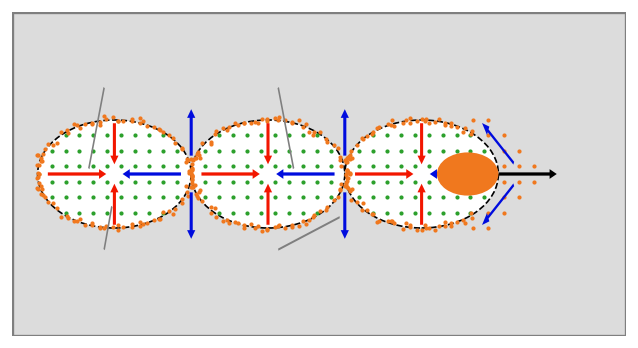

In [23]:
a = 3
b = 1

cav1 = mpatches.Ellipse((2,0), a, b, lw=1, ls='--', ec='black', fc='w')
cav2 = mpatches.Ellipse((5,0), a, b, lw=1, ls='--', ec='black', fc='w')
cav3 = mpatches.Ellipse((8,0), a, b, lw=1, ls='--', ec='black', fc='w')
bunch = mpatches.Ellipse((8.9,0), 1.2, 0.4, fc='#F0781E', zorder=11)
border = mpatches.Rectangle((0,-1.5), 12, 3, lw=2, fc='gainsboro', ec='tab:grey', zorder=0)


fig = plt.figure(figsize=(6.4,3), dpi=120)
ax = fig.subplots()

# plasma
x = np.linspace(0.5, 9.5, 34)
y = np.linspace(-0.5, 0.5, 8)
xx, yy = np.meshgrid(x, y)
mask = ((xx-2)**2/(a/2)**2 + yy**2/(b/2)**2 <= 1) | ((xx-5)**2/(a/2)**2 + yy**2/(b/2)**2 <= 1) | ((xx-8)**2/(a/2)**2 + yy**2/(b/2)**2 <= 1)
ax.plot(xx[mask], yy[mask], marker='.', lw=0, color='tab:green', ms=3)

# cavities and bunch
ax.add_patch(cav1)
ax.add_patch(cav2)
ax.add_patch(cav3)
ax.add_patch(bunch)
ax.add_patch(border)

# electrons
x = np.append([0.5, 0.51, 0.52, 0.54, 0.55, 0.57, 0.59, 0.61, 3.5, 3.49, 3.48, 3.46, 3.44, 3.42], np.linspace(0.5, 3.5, 40))
rand = np.random.normal(size=len(x), scale=0.04)
x += rand 
y = np.zeros((len(x), 2))
y[:, 0] =  np.sqrt((1 - (x-2-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)
y[:, 1] = -np.sqrt((1 - (x-2-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)
ax.plot(x, y, marker='.', lw=0, color='#F0781E', ms=3)

x = np.append([0.5, 0.51, 0.52, 0.54, 0.55, 0.57, 0.59, 0.61, 3.5, 3.49, 3.48, 3.46, 3.44, 3.42], np.linspace(0.5, 3.5, 40)) + 3
rand = np.random.normal(size=len(x), scale=0.04)
x += rand
y = np.zeros((len(x), 2))
y[:, 0] =  np.sqrt((1 - (x-5-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)
y[:, 1] = -np.sqrt((1 - (x-5-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)
ax.plot(x, y, marker='.', lw=0, color='#F0781E', ms=3)

x = np.append([0.5, 0.51, 0.52, 0.54, 0.55, 0.57, 0.59, 0.61], np.linspace(0.5, 3, 35)) + 6
rand = np.random.normal(size=len(x), scale=0.04)
x += rand
y = np.zeros((len(x), 2))
y[:, 0] =  np.sqrt((1 - (x-8-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)
y[:, 1] = -np.sqrt((1 - (x-8-rand)**2 / (a/2)**2)) * b/2 + np.random.normal(size=len(x), scale=0.02)
ax.plot(x, y, marker='.', lw=0, color='#F0781E', ms=3)

x = np.linspace(9, 10.5, 6)
y = np.linspace(-0.5, 0.5, 8)
xx, yy = np.meshgrid(x, y)
mask = ((xx-8)**2/(a/2)**2 + yy**2/(b/2)**2 > 1) & (np.abs(yy) <= -1/2 * (xx-10.5))
ax.plot(xx[mask], yy[mask], marker='.', lw=0, color='#F0781E', ms=3)


# arrows
ax.arrow(9.5, 0, 1, 0, width=0.03, zorder=10, ec='none', color='black', head_width=0.09, head_length=0.14)

# decelerating
ax.arrow(0.7, 0, 1, 0, width=0.03, zorder=10, ec='none', color='#F21600', head_width=0.09, head_length=0.14)
ax.arrow(3.7, 0, 1, 0, width=0.03, zorder=10, ec='none', color='#F21600', head_width=0.09, head_length=0.14)
ax.arrow(6.7, 0, 1, 0, width=0.03, zorder=10, ec='none', color='#F21600', head_width=0.09, head_length=0.14)

# accelerating
ax.arrow(3.3, 0, -1, 0, width=0.03, zorder=10, ec='none', color='#000CDE', head_width=0.09, head_length=0.14)
ax.arrow(6.3, 0, -1, 0, width=0.03, zorder=10, ec='none', color='#000CDE', head_width=0.09, head_length=0.14)
ax.arrow(9.3, 0, -1, 0, width=0.03, zorder=10, ec='none', color='#000CDE', head_width=0.09, head_length=0.14)

# focus
ax.arrow(2, 0.47, 0, -0.3, width=0.06, zorder=10, ec='none', color='#F21600', head_width=0.16,  head_length=0.08)
ax.arrow(5, 0.47, 0, -0.3, width=0.06, zorder=10, ec='none', color='#F21600', head_width=0.16,  head_length=0.08)
ax.arrow(8, 0.47, 0, -0.3, width=0.06, zorder=10, ec='none', color='#F21600', head_width=0.16,  head_length=0.08)

ax.arrow(2, -0.47, 0, 0.3, width=0.06, zorder=10, ec='none', color='#F21600', head_width=0.16,  head_length=0.08)
ax.arrow(5, -0.47, 0, 0.3, width=0.06, zorder=10, ec='none', color='#F21600', head_width=0.16,  head_length=0.08)
ax.arrow(8, -0.47, 0, 0.3, width=0.06, zorder=10, ec='none', color='#F21600', head_width=0.16,  head_length=0.08)

# defocus
ax.arrow(3.5, 0.17, 0, 0.35, width=0.06, zorder=10, ec='none', color='#000CDE', head_width=0.16,  head_length=0.08)
ax.arrow(6.5, 0.17, 0, 0.35, width=0.06, zorder=10, ec='none', color='#000CDE', head_width=0.16,  head_length=0.08)

ax.arrow(3.5, -0.17, 0, -0.35, width=0.06, zorder=10, ec='none', color='#000CDE', head_width=0.16,  head_length=0.08)
ax.arrow(6.5, -0.17, 0, -0.35, width=0.06, zorder=10, ec='none', color='#000CDE', head_width=0.16,  head_length=0.08)

# snowplow
ax.arrow(9.8, 0.1, -0.5, 0.3, width=0.03, zorder=10, ec='none', color='#000CDE', head_width=0.09, head_length=0.14)
ax.arrow(9.8, -0.1, -0.5, -0.3, width=0.03, zorder=10, ec='none', color='#000CDE', head_width=0.09, head_length=0.14)

# text arrows
ax.arrow(1.8, 0.8, -0.3, -0.75, width=0.03, zorder=10, ec='none', color='tab:grey', head_width=0)
ax.arrow(1.8, -0.7, 0.15, 0.4, width=0.03, zorder=10, ec='none', color='tab:grey', head_width=0)
ax.arrow(5.2, 0.8, 0.3, -0.75, width=0.03, zorder=10, ec='none', color='tab:grey', head_width=0)
ax.arrow(5.2, -0.7, 1.2, 0.3, width=0.02, zorder=10, ec='none', color='tab:grey', head_width=0)

ax.set_xlim(0, 12)
ax.set_ylim(-1.5, 1.5)

ax.axis('off')
fig.subplots_adjust(right=0.9, left=0.1, top=0.95, bottom=0.05)

#plt.show()
#plt.savefig(fname="../images/1temp.png", facecolor='white', dpi=100)
plt.savefig(fname="../Vortrag/Images/pwfa.svg")


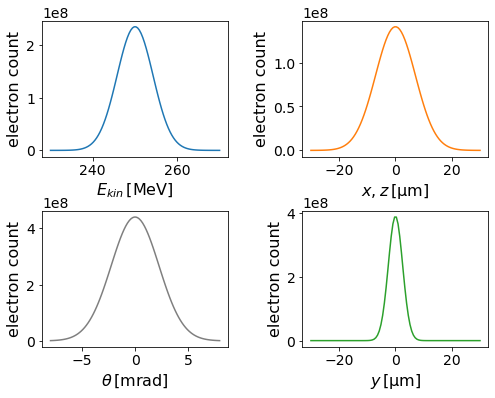

In [121]:
N = 400e-12 / constants.elementary_charge

plt.figure(figsize=(8, 6))

x = np.linspace(230, 270, 100)
E = Gauss_dens(x, 250, 10 / (2*np.sqrt(2*np.log(2))))

plt.subplot(221)
plt.plot(x, E*N)
plt.xlabel("$E_{kin} \, \mathrm{[MeV]}$")
plt.ylabel("electron count")

x = np.linspace(-30, 30, 100)
y = Gauss_dens(x, 0, 10 / np.sqrt(2))

plt.subplot(222)
plt.plot(x, y*N, color="tab:orange")
plt.xlabel("$x, z \, \mathrm{[\mu m]}$")
plt.ylabel("electron count")

s = 20.0e-15 * constants.c / (2*np.sqrt(2*np.log(2))) * 1e6
x = np.linspace(-30, 30, 100)
y = Gauss_dens(x, 0, s)

plt.subplot(224)
plt.plot(x, y*N, color="tab:green")
plt.xlabel("$y \, \mathrm{[\mu m]}$")
plt.ylabel("electron count")

s = 1.6*np.sqrt(2)
x = np.linspace(-8, 8, 100)
y = (Gauss_dens(x, 0, s))

plt.subplot(223)
plt.plot(x, y*N, color="tab:grey")
plt.xlabel(r"$\theta \, \mathrm{[mrad]}$")
plt.ylabel("electron count")

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.savefig(fname="../Vortrag/Images/Distribution.svg", facecolor="white")
#plt.show()

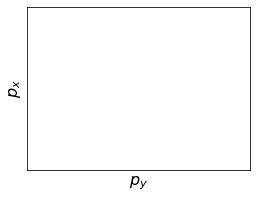

In [108]:
plt.figure(figsize=(4, 3))
plt.plot()
fig.subplots_adjust(left=0)
plt.xlabel("$p_y$")
plt.xticks([])
plt.ylabel("$p_x$")
plt.yticks([])
#plt.show()
plt.savefig(fname="../Vortrag/Images/momentum_graph.svg")
